In [4]:
library(dplyr)
library(ggplot2)
library(Seurat)
library(ggplot2)
library(pheatmap)
set.seed(42)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject



Loading required package: sp

‘SeuratObject’ was built under R 4.4.0 but the current version is
4.4.1; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




In [5]:
library(reticulate)

# Sys.setenv(RETICULATE_PYTHON = "/opt/miniforge3/envs/rstudio_reticulate/bin/python")
reticulate::use_python("/opt/miniforge3/envs/rstudio_reticulate/bin/python", required = TRUE)

# conda_path <- c("/opt/miniforge3/envs/rstudio_reticulate")
# use_condaenv(conda_path, required = TRUE)

py_config()

python:         /mnt/data/miniforge3/envs/rstudio_reticulate/bin/python
libpython:      /opt/miniforge3/envs/rstudio_reticulate/lib/libpython3.9.so
pythonhome:     /mnt/data/miniforge3/envs/rstudio_reticulate:/mnt/data/miniforge3/envs/rstudio_reticulate
version:        3.9.19 (main, Mar 21 2024, 17:11:28)  [GCC 11.2.0]
numpy:          /mnt/data/miniforge3/envs/rstudio_reticulate/lib/python3.9/site-packages/numpy
numpy_version:  1.26.4

NOTE: Python version was forced by use_python() function

In [1]:
## read data
neu_data <- readRDS(
    "../find_optimized_neu_res/output/neurons_trimmed_max_clustered_interval_1.rds"
)
dim(neu_data)
gc()

[1] 40614 67560

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3365144,179.8,6335248,338.4,4721451,252.2
Vcells,978292149,7463.8,1570582265,11982.6,981166830,7485.8


In [4]:
table(neu_data$RNA_snn_res.27)


  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
454 443 430 429 426 419 415 410 408 408 400 391 390 386 384 384 381 378 376 376 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
371 369 362 359 355 354 352 352 351 351 349 347 347 345 345 340 340 339 339 338 
 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60 
338 337 336 334 334 333 333 332 331 330 330 329 328 327 327 325 325 323 323 323 
 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80 
322 321 320 319 315 315 314 313 313 312 312 311 311 309 302 302 299 298 298 298 
 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 
294 293 292 290 289 288 288 288 287 286 286 285 285 284 283 282 281 281 278 278 
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 
277 274 274 272 271 271 270 270 268 267 266 263 260 260 260 259 258 258 258 258 
121 122 123 124 125 126 127

In [6]:
neu_markers<-read.csv("../find_optimized_neu_res/res_27_all_markers.csv")

In [7]:
head(neu_markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,0.000000e+00,2.979047,0.767,0.135,0.000000e+00,1,Sox14
2,4.249433e-228,2.544922,0.824,0.248,1.725865e-223,1,Chchd10
3,1.238907e-216,3.222548,0.379,0.051,5.031698e-212,1,Gpr149
4,2.324775e-177,2.362042,0.478,0.091,9.441843e-173,1,Prdm12
5,6.592713e-166,2.854492,0.350,0.054,2.677564e-161,1,Nr5a1
6,4.200047e-142,3.249436,0.379,0.074,1.705807e-137,1,Ust


In [8]:
# 先过滤掉符合特定模式的行
neu_markers_filtered <- neu_markers %>%
    filter(!grepl("^mt-", gene) & 
           !grepl("^Rp[sl]", gene) & 
           !grepl("^Hb[^(egf)|^(s1l)|^(p1)].+", gene) & 
           !grepl("\\dRik", gene) & 
           !grepl("^Gm\\d", gene))

# 然后筛选marker基因
neu_markers_filtered <- neu_markers_filtered %>%
    filter(pct.1 > 0.2 & p_val_adj < 0.05 & avg_log2FC > 0.6)

head(neu_markers_filtered)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,0.000000e+00,2.979047,0.767,0.135,0.000000e+00,1,Sox14
2,4.249433e-228,2.544922,0.824,0.248,1.725865e-223,1,Chchd10
3,1.238907e-216,3.222548,0.379,0.051,5.031698e-212,1,Gpr149
4,2.324775e-177,2.362042,0.478,0.091,9.441843e-173,1,Prdm12
5,6.592713e-166,2.854492,0.350,0.054,2.677564e-161,1,Nr5a1
6,4.200047e-142,3.249436,0.379,0.074,1.705807e-137,1,Ust


In [9]:
# 6. 每个cluster的基因数量
cluster_gene_counts <- table(neu_markers_filtered$cluster)
print(cluster_gene_counts)


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
 250  122  637  419   68  171  375  380  348  496  163  138  109   96  574  240 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
 183 1975  367  486  616  908  236  505  198  187  173  550  316  406  387  373 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
 953  439  689  263  788  322  260  385  307  247  146  209  267  256  214  215 
  49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64 
 424  158  364  220  975  244  217  194  614  266  302  244  164  283  172  404 
  65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80 
 466  200  424  317  223  210  849  339  134  110  128  265  356  362  329  617 
  81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96 
 165  824  260  573  141  178  331  566  725  295  209  192  421  145  911  372 
  97   98   99  100  101  1

In [10]:
length(unique(neu_markers_filtered$gene))

[1] 7753

In [11]:
neu_markers_filtered <- neu_markers_filtered %>%
  arrange(desc(avg_log2FC))

head(neu_markers_filtered)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,0,10.074795,0.439,0.001,0,20,Emx1
2,0,9.391512,0.212,0.001,0,242,Irx6
3,0,8.989730,0.237,0.002,0,95,Crh
4,0,8.905985,0.692,0.004,0,242,Barhl1
5,0,8.593868,0.476,0.001,0,18,Grin2c
6,0,8.536205,0.507,0.002,0,242,Foxa1


In [12]:
# 按照cluster分组并筛选每个组的avg_log2FC排名前50基因
top50_genes <- neu_markers_filtered %>%
    group_by(cluster) %>%
    top_n(50, avg_log2FC) %>%
    ungroup()

# 查看每个cluster的top 50基因
print(top50_genes)

# A tibble: 13,600 × 7
   p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene   
   <dbl>      <dbl> <dbl> <dbl>     <dbl>   <int> <chr>  
 1     0      10.1  0.439 0.001         0      20 Emx1   
 2     0       9.39 0.212 0.001         0     242 Irx6   
 3     0       8.99 0.237 0.002         0      95 Crh    
 4     0       8.91 0.692 0.004         0     242 Barhl1 
 5     0       8.59 0.476 0.001         0      18 Grin2c 
 6     0       8.54 0.507 0.002         0     242 Foxa1  
 7     0       8.41 0.644 0.034         0      71 Ghrh   
 8     0       8.16 0.459 0.006         0     242 Irx5   
 9     0       8.14 0.902 0.014         0      20 Neurod6
10     0       8.10 0.534 0.003         0     242 Lmx1b  
# ℹ 13,590 more rows


In [13]:
# 保存neu_markers_filtered为CSV文件
write.csv(neu_markers_filtered, "clust27_markers_filtered.csv", row.names = FALSE)

In [14]:
# 保存top50基因为CSV文件
write.csv(top50_genes, "clust27_top50_genes.csv", row.names = FALSE)

In [6]:
top50_genes<-read.csv("clust27_top50_genes.csv")

In [30]:
table(neu_data$RNA_snn_res.27,neu_data$Batch)

     
      E11_S1 E11_S2 E13_S1 E14_S1 E14_S2 E15_S1 E15_S2 P0_S1 P0_S2 P7_S1
  1        6      6     17     76     76     36    156    47    34     0
  2        0      0     75     69     81    101     60    30    27     0
  3       15     15     64    136    141     26      4    15    14     0
  4        0      0     27    201    177      6      9     4     5     0
  5       10     10     69    146    134     51      1     2     3     0
  6        0      0      3     87     84     51      2    84    87    21
  7        0      0      2     72     71     47     18    69    75    61
  8       23     23     51     29     25     85    117    29    26     2
  9        0      3     10     45     40     34     21    92    92    71
  10       0      0      1    132    131      4      0    71    69     0
  11       0      0      9     94     99     53     88    29    28     0
  12      10      8     76    138    139     16      0     2     2     0
  13       2      2     59     98     85    1

In [16]:
# 1. 获取变量基因
variable_features <- VariableFeatures(neu_data)

# 2. 提取integrated.jointpca空间的数据
integrated_data <- Embeddings(neu_data, reduction = "integrated.jointpca")

In [23]:
head(integrated_data)

,integratedjointpca_1,integratedjointpca_2,integratedjointpca_3,integratedjointpca_4,integratedjointpca_5,integratedjointpca_6,integratedjointpca_7,integratedjointpca_8,integratedjointpca_9,integratedjointpca_10,⋯,integratedjointpca_41,integratedjointpca_42,integratedjointpca_43,integratedjointpca_44,integratedjointpca_45,integratedjointpca_46,integratedjointpca_47,integratedjointpca_48,integratedjointpca_49,integratedjointpca_50
__E11_S1_CTCAACCGTTCTCACC-1,5.101886,-3.440808,-1.7310405,-2.2362739,0.6799631,-3.528560,-0.1847808,1.16162256,-2.0996878,-0.6828121,⋯,1.5046512,-1.9432156,1.3475549,-1.283607,1.2508158,0.4745274,1.50235579,1.3981648,-1.65128731,-1.1029624
__E11_S1_GTCCCATGTTACCTGA-1,7.658376,-3.991943,1.2735465,-0.8123892,-8.4261231,5.624314,2.6845783,0.01135505,-1.3370255,-3.4859556,⋯,-1.5140714,0.8747227,1.2326293,-2.783220,-0.6665445,-2.8382257,0.74603069,1.2779026,0.62788449,-1.3078443
__E11_S1_TTCCGTGTCAACGCTA-1,5.440296,-3.857614,0.8017796,-0.5614814,-7.8183387,5.889303,2.8004908,-0.24541450,-0.9979149,-2.7389536,⋯,-1.7794259,0.4051002,0.9448664,-2.597357,-0.9802772,-2.8504752,0.47344490,0.9179756,0.05741784,-1.1881208
__E11_S1_GCGTTTCAGAATTGCA-1,1.118615,-3.744488,5.0287830,-1.2602556,2.4415725,1.602416,2.3968996,-2.54318361,-4.9400185,-0.1250033,⋯,0.4827074,0.7446278,-2.4031067,-0.269886,0.9783132,-0.9608542,-0.04137698,0.2659727,-0.61860519,-0.6422539
__E11_S1_GAAGCGACATTGGATC-1,9.651693,-3.805120,1.3404900,-1.6776785,-7.2424599,6.302718,2.5858112,-0.52973257,-1.8718860,-3.0665275,⋯,-2.2392383,0.5411118,2.1406445,-3.580687,-0.4938109,-3.5375670,1.43566603,1.2803073,0.60109799,-1.9039869
__E11_S1_CCGTGAGTCTGTCTCG-1,10.694666,-4.031714,2.3378860,-0.9870047,-7.4303769,6.118525,2.8221808,0.24682416,-2.0951137,-3.3481588,⋯,-2.4538041,0.7894768,2.2527358,-3.287935,-0.5554323,-3.9007759,0.83801607,1.1005874,0.58342732,-2.0409987


In [17]:
# 3. 创建伪批量数据
pseudobulk_data <- integrated_data %>%
  as.data.frame() %>%
  mutate(cluster = neu_data$RNA_snn_res.27) %>%
  group_by(cluster) %>%
  summarize(across(everything(), mean))

In [24]:
# 4. 计算距离矩阵
distance_matrix <- dist(pseudobulk_data[, -1])  # 排除cluster列

# 5. 将距离矩阵转换为矩阵形式
distance_matrix <- as.matrix(distance_matrix)

# 6. 查看距离矩阵
print(distance_matrix)

dim(distance_matrix)


            1         2         3         4         5         6         7
1    0.000000 14.742223 15.076683 14.054805 10.362488 16.252335 15.867926
2   14.742223  0.000000 20.005490 16.061030 13.508953 15.356517 14.334228
3   15.076683 20.005490  0.000000 14.749513 14.894745 19.745651 18.190793
4   14.054805 16.061030 14.749513  0.000000  9.723542 14.993973 12.951630
5   10.362488 13.508953 14.894745  9.723542  0.000000 12.728588 13.083860
6   16.252335 15.356517 19.745651 14.993973 12.728588  0.000000 13.932483
7   15.867926 14.334228 18.190793 12.951630 13.083860 13.932483  0.000000
8   14.304086  7.983067 21.154775 17.607119 13.236886 15.912521 14.599050
9   13.910010 13.284551 18.043561 13.251811 12.003953  9.748473  7.771775
10  19.832798 20.216361 19.808752 14.548113 17.462383 19.167499 16.989181
11  14.855824  5.167894 18.479521 14.155874 13.368106 14.413736 12.372444
12  15.266470 14.486897 19.585988 14.239635  9.979204 13.769411 14.734728
13  16.410541 13.568128 21.146334 16.8

[1] 272 272

[1] "图像已成功保存！"


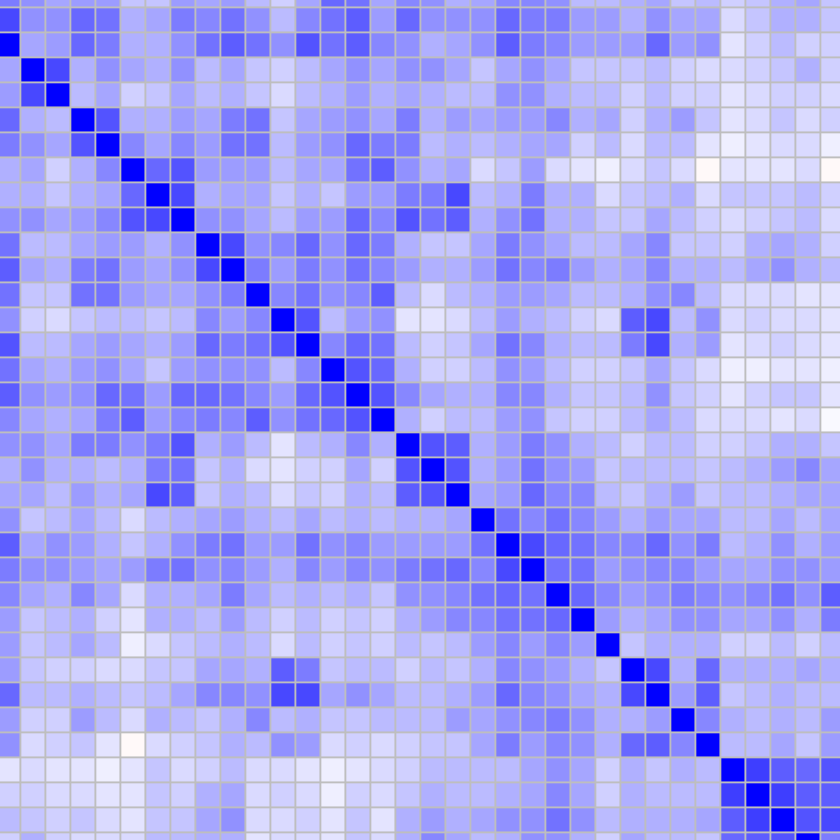

In [39]:
# 创建热图并保存为 ggplot 对象
heatmap_plot <- pheatmap(distance_matrix, 
         main = "Cluster Distance in integrated.jointpca Space",
         fontsize = 10,  
         cellwidth = 15,  
         cellheight = 15,  
         border_color = "grey",  
         color = colorRampPalette(c("blue", "white", "red"))(50),  
         clustering_distance_rows = "euclidean",  
         clustering_distance_cols = "euclidean",  
         clustering_method = "complete",  
         show_rownames = TRUE,  
         show_colnames = TRUE,  
         fontsize_row = 8,  
         fontsize_col = 8)

# 保存图像
ggsave("cluster27_distance_matrix.png", plot = heatmap_plot$gtable, width = 150, height = 150, units = "cm", limitsize = F)

# 检查保存的文件是否存在
if (file.exists("cluster27_distance_matrix.png")) {
    print("图像已成功保存！")
} else {
    print("图像保存失败，请检查路径和权限。")
}

[1] "图像已成功保存！"


In [32]:
rownames(distance_matrix)
colnames(distance_matrix)

[1] "1"   "2"   "3"   "4"   "5"   "6"   "7"   "8"   "9"   "10"  "11"  "12" 
 [13] "13"  "14"  "15"  "16"  "17"  "18"  "19"  "20"  "21"  "22"  "23"  "24" 
 [25] "25"  "26"  "27"  "28"  "29"  "30"  "31"  "32"  "33"  "34"  "35"  "36" 
 [37] "37"  "38"  "39"  "40"  "41"  "42"  "43"  "44"  "45"  "46"  "47"  "48" 
 [49] "49"  "50"  "51"  "52"  "53"  "54"  "55"  "56"  "57"  "58"  "59"  "60" 
 [61] "61"  "62"  "63"  "64"  "65"  "66"  "67"  "68"  "69"  "70"  "71"  "72" 
 [73] "73"  "74"  "75"  "76"  "77"  "78"  "79"  "80"  "81"  "82"  "83"  "84" 
 [85] "85"  "86"  "87"  "88"  "89"  "90"  "91"  "92"  "93"  "94"  "95"  "96" 
 [97] "97"  "98"  "99"  "100" "101" "102" "103" "104" "105" "106" "107" "108"
[109] "109" "110" "111" "112" "113" "114" "115" "116" "117" "118" "119" "120"
[121] "121" "122" "123" "124" "125" "126" "127" "128" "129" "130" "131" "132"
[133] "133" "134" "135" "136" "137" "138" "139" "140" "141" "142" "143" "144"
[145] "145" "146" "147" "148" "149" "150" "151" "152" "153" "154" "155" "156"
[157] "157" "158" "159" "160" "161" "162" "163" "164" "165" "166" "167" "168"
[169] "169" "170" "171" "172" "173" "174" "175" "176" "177" "178" "179" "180"
[181] "181" "182" "183" "184" "185" "186" "187" "188" "189" "190" "191" "192"
[193] "193" "194" "195" "196" "197" "198" "199" "200" "201" "202" "203" "204"
[205] "205" "206" "207" "208" "209" "210" "211" "212" "213" "214" "215" "216"
[217] "217" "218" "219" "220" "221" "222" "223" "224" "225" "226" "227" "228"
[229] "229" "230" "231" "232" "233" "234" "235" "236" "237" "238" "239" "240"
[241] "241" "242" "243" "244" "245" "246" "247" "248" "249" "250" "251" "252"
[253] "253" "254" "255" "256" "257" "258" "259" "260" "261" "262" "263" "264"
[265] "265" "266" "267" "268" "269" "270" "271" "272"

[1] "1"   "2"   "3"   "4"   "5"   "6"   "7"   "8"   "9"   "10"  "11"  "12" 
 [13] "13"  "14"  "15"  "16"  "17"  "18"  "19"  "20"  "21"  "22"  "23"  "24" 
 [25] "25"  "26"  "27"  "28"  "29"  "30"  "31"  "32"  "33"  "34"  "35"  "36" 
 [37] "37"  "38"  "39"  "40"  "41"  "42"  "43"  "44"  "45"  "46"  "47"  "48" 
 [49] "49"  "50"  "51"  "52"  "53"  "54"  "55"  "56"  "57"  "58"  "59"  "60" 
 [61] "61"  "62"  "63"  "64"  "65"  "66"  "67"  "68"  "69"  "70"  "71"  "72" 
 [73] "73"  "74"  "75"  "76"  "77"  "78"  "79"  "80"  "81"  "82"  "83"  "84" 
 [85] "85"  "86"  "87"  "88"  "89"  "90"  "91"  "92"  "93"  "94"  "95"  "96" 
 [97] "97"  "98"  "99"  "100" "101" "102" "103" "104" "105" "106" "107" "108"
[109] "109" "110" "111" "112" "113" "114" "115" "116" "117" "118" "119" "120"
[121] "121" "122" "123" "124" "125" "126" "127" "128" "129" "130" "131" "132"
[133] "133" "134" "135" "136" "137" "138" "139" "140" "141" "142" "143" "144"
[145] "145" "146" "147" "148" "149" "150" "151" "152" "153" "154" "155" "156"
[157] "157" "158" "159" "160" "161" "162" "163" "164" "165" "166" "167" "168"
[169] "169" "170" "171" "172" "173" "174" "175" "176" "177" "178" "179" "180"
[181] "181" "182" "183" "184" "185" "186" "187" "188" "189" "190" "191" "192"
[193] "193" "194" "195" "196" "197" "198" "199" "200" "201" "202" "203" "204"
[205] "205" "206" "207" "208" "209" "210" "211" "212" "213" "214" "215" "216"
[217] "217" "218" "219" "220" "221" "222" "223" "224" "225" "226" "227" "228"
[229] "229" "230" "231" "232" "233" "234" "235" "236" "237" "238" "239" "240"
[241] "241" "242" "243" "244" "245" "246" "247" "248" "249" "250" "251" "252"
[253] "253" "254" "255" "256" "257" "258" "259" "260" "261" "262" "263" "264"
[265] "265" "266" "267" "268" "269" "270" "271" "272"

     
      1 2 3 4 5 6 7 8 9 10
  1   0 0 0 0 0 0 0 0 1  0
  2   0 0 0 0 0 0 1 0 0  0
  3   0 0 0 0 0 0 1 0 0  0
  4   0 0 0 0 0 0 0 0 1  0
  5   0 0 0 0 0 0 1 0 0  0
  6   0 0 0 0 0 0 1 0 0  0
  7   0 0 0 0 0 0 1 0 0  0
  8   0 0 0 0 0 0 1 0 0  0
  9   0 1 0 0 0 0 0 0 0  0
  10  0 0 0 0 0 0 1 0 0  0
  11  0 0 0 0 1 0 0 0 0  0
  12  0 0 0 0 0 0 1 0 0  0
  13  0 0 0 0 0 0 1 0 0  0
  14  0 0 0 0 0 0 0 1 0  0
  15  0 0 0 0 0 0 1 0 0  0
  16  0 0 0 0 0 0 1 0 0  0
  17  0 0 0 0 0 0 1 0 0  0
  18  0 0 0 0 0 0 1 0 0  0
  19  0 0 0 0 0 0 1 0 0  0
  20  0 0 0 0 0 0 1 0 0  0
  21  0 0 0 0 0 0 1 0 0  0
  22  0 0 0 0 0 0 1 0 0  0
  23  0 0 0 0 0 0 1 0 0  0
  24  0 0 0 0 0 0 1 0 0  0
  25  0 0 0 0 0 0 1 0 0  0
  26  0 0 0 0 0 0 0 0 1  0
  27  0 0 0 0 0 0 1 0 0  0
  28  0 0 0 0 0 0 1 0 0  0
  29  0 0 0 0 0 0 1 0 0  0
  30  0 0 0 0 0 0 1 0 0  0
  31  0 0 0 0 0 0 1 0 0  0
  32  0 1 0 0 0 0 0 0 0  0
  33  0 0 0 0 0 0 1 0 0  0
  34  0 0 0 0 0 0 0 0 0  1
  35  0 0 0 0 0 0 1 0 0  0
  36  0 0 0 0 0 0 0 0 

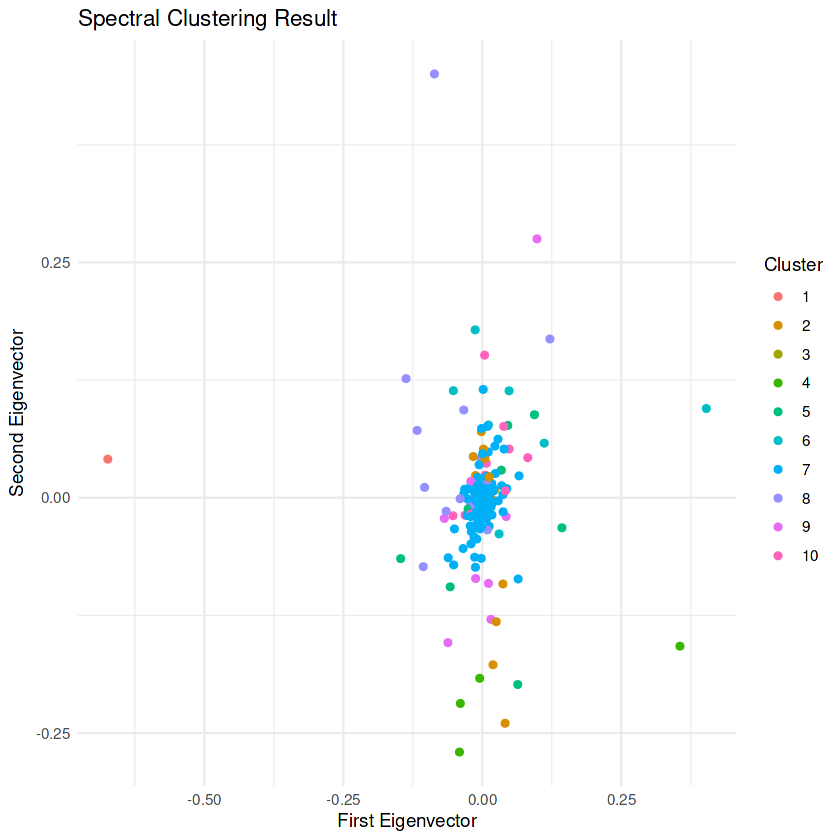

In [40]:
# 1. 准备数据
# 假设 pseudobulk_data 已经准备好
pseudobulk_data_numeric <- pseudobulk_data[, !colnames(pseudobulk_data) %in% c("cluster")]

# 2. 计算相似度矩阵
similarity_matrix <- exp(-as.matrix(dist(pseudobulk_data_numeric))^2 / (2 * median(dist(pseudobulk_data_numeric))^2))

# 3. 构建拉普拉斯矩阵
D <- diag(rowSums(similarity_matrix))
L <- D - similarity_matrix
L_norm <- solve(sqrt(D)) %*% L %*% solve(sqrt(D))

# 4. 特征值分解
eigen_result <- eigen(L_norm)

# 5. 选择前 k 个特征向量
k <- 10  # 可以根据需要调整
selected_eigenvectors <- eigen_result$vectors[, 1:k]

# 6. 对特征向量进行 K-means 聚类
set.seed(42)  # 为了结果可重复
kmeans_result <- kmeans(selected_eigenvectors, centers = k)

# 7. 获取聚类结果
cluster_assignments <- kmeans_result$cluster

# 8. 可视化结果（使用前两个主成分）
library(ggplot2)

plot_data <- data.frame(
  PC1 = selected_eigenvectors[, 1],
  PC2 = selected_eigenvectors[, 2],
  Cluster = as.factor(cluster_assignments),
  Original_Cluster = pseudobulk_data$cluster
)

ggplot(plot_data, aes(x = PC1, y = PC2, color = Cluster)) +
  geom_point() +
  theme_minimal() +
  labs(title = "Spectral Clustering Result",
       x = "First Eigenvector",
       y = "Second Eigenvector")

# 9. 比较原始聚类和谱聚类结果
results <- data.frame(
  Original_Cluster = pseudobulk_data$cluster,
  Spectral_Cluster = cluster_assignments
)

# 打印结果
print(table(results$Original_Cluster, results$Spectral_Cluster))

# 可选：保存结果到文件
# write.csv(results, "spectral_clustering_results.csv", row.names = FALSE)

     
      1 2 3 4 5 6 7 8 9 10
  1   0 0 0 0 0 0 0 0 1  0
  2   0 0 0 0 0 0 1 0 0  0
  3   0 0 0 0 0 0 1 0 0  0
  4   0 0 0 0 0 0 0 0 1  0
  5   0 0 0 0 0 0 1 0 0  0
  6   0 0 0 0 0 0 1 0 0  0
  7   0 0 0 0 0 0 1 0 0  0
  8   0 0 0 0 0 0 1 0 0  0
  9   0 1 0 0 0 0 0 0 0  0
  10  0 0 0 0 0 0 1 0 0  0
  11  0 0 0 0 1 0 0 0 0  0
  12  0 0 0 0 0 0 1 0 0  0
  13  0 0 0 0 0 0 1 0 0  0
  14  0 0 0 0 0 0 0 1 0  0
  15  0 0 0 0 0 0 1 0 0  0
  16  0 0 0 0 0 0 1 0 0  0
  17  0 0 0 0 0 0 1 0 0  0
  18  0 0 0 0 0 0 1 0 0  0
  19  0 0 0 0 0 0 1 0 0  0
  20  0 0 0 0 0 0 1 0 0  0
  21  0 0 0 0 0 0 1 0 0  0
  22  0 0 0 0 0 0 1 0 0  0
  23  0 0 0 0 0 0 1 0 0  0
  24  0 0 0 0 0 0 1 0 0  0
  25  0 0 0 0 0 0 1 0 0  0
  26  0 0 0 0 0 0 0 0 1  0
  27  0 0 0 0 0 0 1 0 0  0
  28  0 0 0 0 0 0 1 0 0  0
  29  0 0 0 0 0 0 1 0 0  0
  30  0 0 0 0 0 0 1 0 0  0
  31  0 0 0 0 0 0 1 0 0  0
  32  0 1 0 0 0 0 0 0 0  0
  33  0 0 0 0 0 0 1 0 0  0
  34  0 0 0 0 0 0 0 0 0  1
  35  0 0 0 0 0 0 1 0 0  0
  36  0 0 0 0 0 0 0 0 

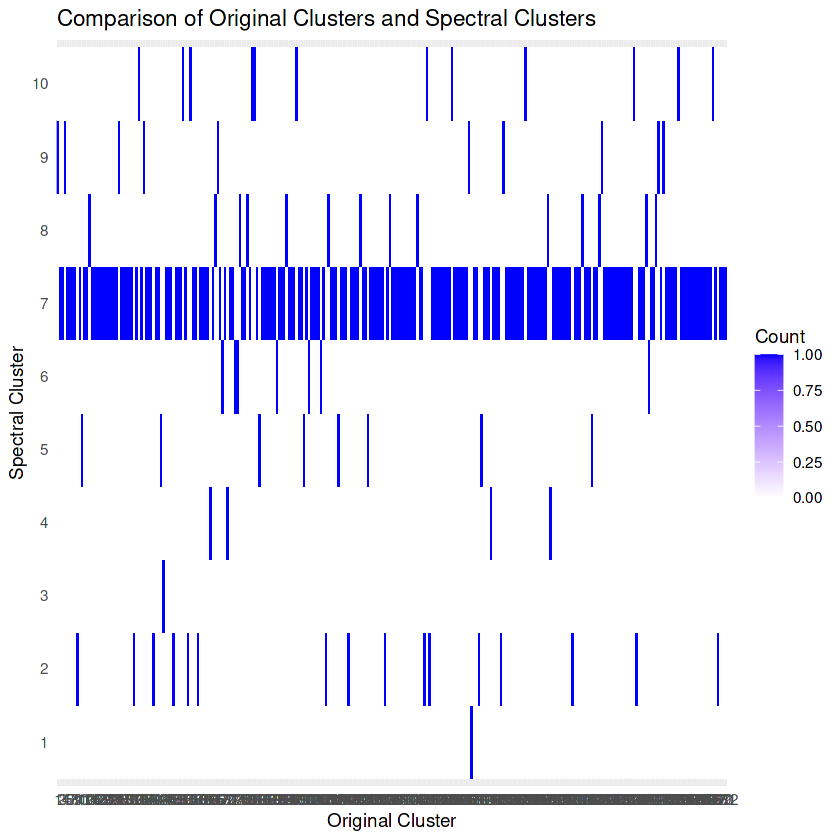

In [41]:
# 9. 比较原始聚类和谱聚类结果
results <- data.frame(
  Original_Cluster = pseudobulk_data$cluster,  # 原始聚类
  Spectral_Cluster = cluster_assignments          # 谱聚类结果
)

# 创建交叉表
contingency_table <- table(results$Original_Cluster, results$Spectral_Cluster)

# 打印交叉表
print(contingency_table)

# 可视化交叉表
library(ggplot2)
library(reshape2)

# 将交叉表转换为数据框以便于可视化
contingency_df <- as.data.frame(contingency_table)
colnames(contingency_df) <- c("Original_Cluster", "Spectral_Cluster", "Count")

In [45]:
# 绘制热图并保存
heatmap_plot <- ggplot(contingency_df, aes(x = Original_Cluster, y = Spectral_Cluster, fill = Count)) +
  geom_tile(color = "black") +  # 添加黑色边框
  scale_fill_gradient(low = "white", high = "blue", name = "Count") +  # 自定义颜色渐变
  labs(title = "Comparison of Original Clusters and Spectral Clusters",
       x = "Original Cluster",
       y = "Spectral Cluster") +
  theme_minimal(base_size = 15) +  # 增加基础字体大小
  theme(axis.text.x = element_text(angle = 45, hjust = 1),  # 旋转 x 轴标签
        panel.grid.major = element_blank(),  # 去掉主要网格线
        panel.grid.minor = element_blank())

# 保存热图
ggsave("comparison_heatmap.png", plot = heatmap_plot, width = 100, height = 8, dpi = 300,limitsize = F)

In [25]:
# 神经递质
mouse_neu_transmitter <- read.csv("../NT.csv")
head(mouse_neu_transmitter)

,Type,Gene
,<chr>,<chr>
1,Glutamatergic,Slc17a7
2,Glutamatergic,Slc17a6
3,Glutamatergic,Slc17a8
4,GABAergic,Gad1
5,GABAergic,Gad2
6,GABAergic,Aldh1a1


In [38]:
# 使用 paste 函数将所有基因名连接成一个字符串，用逗号分隔
genes_string <- paste(mouse_neu_transmitter$Gene, collapse = ", ")

# 打印结果
cat(genes_string)

Slc17a7, Slc17a6, Slc17a8, Gad1, Gad2, Aldh1a1, Slc32a1, Slc18a2, Gad1, Gad2, Slc6a5, Slc6a9, Slc18a3, Chat, Slc6a3, Slc18a2, Th, Ddc, Slc6a2, Slc18a2, Pnmt, Dbh, Slc6a4, Slc18a2, Tph2, Ddc, Slc18a2, Hdc

In [28]:
# 按Type分组并收集基因
grouped_genes <- split(mouse_neu_transmitter$Gene, mouse_neu_transmitter$Type)

# 打印结果
for (type in names(grouped_genes)) {
  cat(paste0(type, ":\n"))
  cat(paste(grouped_genes[[type]], collapse = ", "))
  cat("\n\n")
}

Cholinergic :
Slc18a3, Chat

Dopaminergic:
Slc6a3, Slc18a2, Th, Ddc

GABAergic :
Gad1, Gad2, Aldh1a1, Slc32a1, Slc18a2

Glutamatergic :
Slc17a7, Slc17a6, Slc17a8

Glycinergic :
Gad1, Gad2, Slc6a5, Slc6a9

Histaminergic:
Slc18a2, Hdc

Noradrenergic:
Slc6a2, Slc18a2, Pnmt, Dbh

Serotonergic:
Slc6a4, Slc18a2, Tph2, Ddc



In [92]:
neu_transmitter_genes <- mouse_neu_transmitter$Gene

# 2. 使用RNA_snn_res.27进行pseudobulk处理
Idents(neu_data) <- "RNA_snn_res.27"
pseudobulk_nt <- AggregateExpression(neu_data, 
                                     features = neu_transmitter_genes,
                                     group.by = "ident",
                                     assays = "RNA",
                                     slot = "scale.data",
                                     return.seurat = FALSE)

In [93]:
# head(pseudobulk_nt)

In [94]:
# 转置矩阵使得行为聚类，列为基因
pseudobulk_nt <- t(pseudobulk_nt$RNA)
# 3. 对处理后的数据进行标准化
pseudobulk_nt_scaled <- scale(pseudobulk_nt)

In [95]:
# 4. 进行层次聚类
hc <- hclust(dist(pseudobulk_nt_scaled), method = "ward.D2")

# 5. 可视化聚类结果
pdf("neurotransmitter_clustering.pdf", width = 12, height = 8)
plot(hc, main = "Hierarchical Clustering of Clusters based on Neurotransmitter Genes", xlab = "", sub = "")
dev.off()

pdf 
  2

In [96]:
# 7. K-means聚类（可选）
k <- 50  # 假设我们想要5个聚类
kmeans_result <- kmeans(pseudobulk_nt_scaled, centers = k)

# 8. 可视化K-means聚类结果
pca_result <- prcomp(pseudobulk_nt_scaled)
pca_df <- as.data.frame(pca_result$x[,1:2])
pca_df$cluster <- factor(kmeans_result$cluster)

pdf("kmeans_clustering.pdf", width = 10, height = 8)
ggplot(pca_df, aes(x = PC1, y = PC2, color = cluster)) +
  geom_point(size = 3) +
  theme_minimal() +
  labs(title = "K-means Clustering of Clusters based on Neurotransmitter Gene Expression")
dev.off()

pdf 
  2

In [97]:
# 根据K-means聚类结果对数据进行排序
ordered_clusters <- order(kmeans_result$cluster)
pseudobulk_nt_scaled_ordered <- pseudobulk_nt_scaled[ordered_clusters, ]

# 创建一个数据框来存储聚类信息
cluster_info <- data.frame(Cluster = kmeans_result$cluster[ordered_clusters])

# 使用pheatmap绘制热图
library(pheatmap)
library(grid)
library(ggplot2)

# 创建自定义的行名（原始cluster编号）
row_labels <- paste0("Cluster ", rownames(pseudobulk_nt_scaled_ordered))

# 创建一个数据框来存储原始聚类和kmeans聚类信息
cluster_info <- data.frame(
  Original_Cluster = factor(rownames(pseudobulk_nt_scaled_ordered)),
  KMeans_Cluster = factor(kmeans_result$cluster[ordered_clusters])
)

# 创建热图对象
heatmap_plot <- pheatmap(pseudobulk_nt_scaled_ordered,
         annotation_row = cluster_info,
         show_rownames = TRUE,  # 显示行名
         labels_row = row_labels,  # 使用自定义的行名
         cluster_rows = T,
         cluster_cols = TRUE,
         main = "Heatmap of Neurotransmitter Gene Expression Across Clusters",
         fontsize = 8,
         fontsize_row = 6,  # 调整行名字体大小
         annotation_names_row = TRUE,
         annotation_legend = TRUE,
         color = colorRampPalette(c("white", "red"))(100),  # 从白色到红色的渐变
         silent = TRUE)  # 设置silent = TRUE以返回图形对象而不是直接绘制

# 使用ggsave保存热图
ggsave("neurotransmitter_k50_heatmap.png", plot = heatmap_plot$gtable, width = 20, height = 15, units = "in", dpi = 300)

# 检查文件是否成功保存
if (file.exists("neurotransmitter_k50_heatmap.png")) {
    print("热图已成功保存为PNG文件！")
} else {
    print("热图保存失败，请检查路径和权限。")
}

[1] "热图已成功保存为PNG文件！"


## 结束数据探索，正式开始手动注释。
1. 绘制神经递质的热图
2. 绘制神经肽的热图
3. 神经递质tag：创建一个列表，key=NT，value=聚类编号
4. 神经肽tag：创建一个列表，key=NP，value=聚类编号
5. 得到神经递质+神经肽的组合tag
6. 利用得到的组合tag去注释res.27的神经元

In [76]:
mouse_neu_transmitter

Type,Gene
<chr>,<chr>
Glutamatergic,Slc17a7
Glutamatergic,Slc17a6
Glutamatergic,Slc17a8
GABAergic,Gad1
GABAergic,Gad2
GABAergic,Aldh1a1
GABAergic,Slc32a1
GABAergic,Slc18a2
Glycinergic,Gad1


In [77]:
mouse_neu_peptides<-read.csv("../human2mouse__neu_peptides.csv",row.names = 1)
head(mouse_neu_peptides)

,x
,<chr>
1,Adcyap1
2,Adm
3,Adm2
4,Agrp
5,Agt
6,Apln


In [78]:
mouse_neu_peptides<-unique(mouse_neu_peptides)
head(mouse_neu_peptides)

,x
,<chr>
1,Adcyap1
2,Adm
3,Adm2
4,Agrp
5,Agt
6,Apln


In [80]:
# 获取神经递质基因列表
nt_genes <- unique(mouse_neu_transmitter$Gene)


In [81]:

# # 使用RNA_snn_res.27进行pseudobulk处理
# Idents(neu_data) <- "RNA_snn_res.27"
# pseudobulk_nt <- AggregateExpression(neu_data, 
#                                      features = nt_genes,
#                                      group.by = "ident",
#                                      assays = "RNA",
#                                      slot = "scale.data",
#                                      return.seurat = FALSE)

# # 转置矩阵并进行标准化
# pseudobulk_nt <- t(pseudobulk_nt$RNA)
# pseudobulk_nt_scaled <- scale(pseudobulk_nt)


In [98]:

# 创建热图
library(pheatmap)
library(RColorBrewer)

nt_heatmap <- pheatmap(pseudobulk_nt_scaled,
         show_rownames = TRUE,
         show_colnames = TRUE,
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         main = "神经递质基因表达热图",
         fontsize = 8,
         fontsize_row = 6,
         fontsize_col = 6,
         color = colorRampPalette(c("white", "red"))(100),
         silent = TRUE)

# 保存热图
ggsave("neurotransmitter_heatmap.png", plot = nt_heatmap$gtable, width = 20, height = 55, units = "in", dpi = 300, limitsize = F)


In [99]:
# 获取神经肽基因列表
np_genes <- mouse_neu_peptides$x


In [100]:
# 使用RNA_snn_res.27进行pseudobulk处理
pseudobulk_np <- AggregateExpression(neu_data, 
                                     features = np_genes,
                                     group.by = "ident",
                                     assays = "RNA",
                                     slot = "scale.data",
                                     return.seurat = FALSE)

# 转置矩阵并进行标准化
pseudobulk_np <- t(pseudobulk_np$RNA)
pseudobulk_np_scaled <- scale(pseudobulk_np)


Warning message:
“The following 8 features were not found in the RNA assay: Ppy, Prl7b1, Prl7d1, Prl7a2, Prl2c5, Prl2b1, Prl2c2, Prl8a6”


In [102]:
# 创建热图
np_heatmap <- pheatmap(pseudobulk_np_scaled,
         show_rownames = TRUE,
         show_colnames = TRUE,
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         main = "神经肽基因表达热图",
         fontsize = 8,
         fontsize_row = 6,
         fontsize_col = 6,
         color = colorRampPalette(c("white", "red"))(100),
         silent = TRUE)

# 保存热图
ggsave("neuropeptide_heatmap.png", plot = np_heatmap$gtable, width = 30, height = 55, units = "in", dpi = 300,limitsize = F)

In [12]:
Reductions(neu_data)

[1] "noregress_pca"               "pca"                        
[3] "unintegrated_noregress_umap" "unintegrated_regressed_umap"
[5] "integrated.jointpca"         "integrated_regressed_umap"

In [4]:
# 绘制一张dimplot，用红色高亮表示neu_data中的每一个cluster，并保存为长图
# 获取唯一的聚类编号
cluster_list <- unique(neu_data$RNA_snn_res.27)

# 创建一个列表来存储每个聚类的图
plot_list <- list()

# 为每个聚类生成一个图
for (cluster in cluster_list) {
  plot <- DimPlot(
    neu_data,
    reduction = "integrated_regressed_umap",  # 假设您使用UMAP进行可视化,如果使用其他方法请相应修改
    group.by = "RNA_snn_res.27",
    raster = FALSE,
    label = TRUE,
    label.size = 3,
    cells.highlight = WhichCells(neu_data, expression = RNA_snn_res.27 == cluster),
    cols.highlight = "red",
    cols = "gray"
  ) + 
    ggtitle(paste("Cluster", cluster)) +
    NoLegend()
  
  plot_list[[as.character(cluster)]] <- plot
}

# 组合所有图
library(patchwork)
combined_plot <- wrap_plots(plot_list, ncol = 5)  # 每行5个图,可以根据需要调整

# 添加主标题
final_plot <- combined_plot + 
  plot_annotation(title = "Clusters (RNA_snn_res.27)", 
                  theme = theme(plot.title = element_text(size = 20, hjust = 0.5)))

In [5]:
pdf("clusters_RNA_snn_res.27.pdf", width = 30, height = 200)
print(final_plot)
dev.off()

pdf 
  2

In [1]:
# 直接在cellxgene上可视化
if (!dir.exists("./conversion_files/")) {
  dir.create("./conversion_files")
}

In [31]:
neu_data<- JoinLayers(neu_data)

In [32]:
library(Matrix)
sparse_matrix <- as(neu_data@assays$RNA@layers$data, "sparseMatrix")
Matrix::writeMM(sparse_matrix, file = "./conversion_files/RNA_counts.mtx")

NULL

In [17]:
neu_data@meta.data %>%
  tibble::rownames_to_column("Cell_ID") %>%
  readr::write_csv(file = "./conversion_files/cell_metadata.csv",
                   col_names = TRUE)

In [ ]:
readr::write_csv(data.frame(cell = colnames(neu_data)), 
                 file = "./conversion_files/cells.csv", 
                 col_names = TRUE)

In [29]:
readr::write_csv(data.frame(gene = rownames(neu_data)), 
                 file = "./conversion_files/genes.csv", 
                 col_names = TRUE)

In [11]:
readr::write_csv(as.data.frame(neu_data@reductions$integrated.jointpca@cell.embeddings),
                 file = "./conversion_files/PCA.csv",
                 col_names = TRUE)
readr::write_csv(as.data.frame(neu_data@reductions$integrated_regressed_umap@cell.embeddings),
                 file = "./conversion_files/UMAP.csv",
                 col_names = TRUE)

In [ ]:
readr::write_csv(as.data.frame(neu_data@reductions$integrated_regressed_umap@cell.embeddings),
                 file = "./conversion_files/UMAP.csv",
                 col_names = TRUE)

In [15]:
head(rownames(neu_data@meta.data))

[1] "__E11_S1_CTCAACCGTTCTCACC-1" "__E11_S1_GTCCCATGTTACCTGA-1"
[3] "__E11_S1_TTCCGTGTCAACGCTA-1" "__E11_S1_GCGTTTCAGAATTGCA-1"
[5] "__E11_S1_GAAGCGACATTGGATC-1" "__E11_S1_CCGTGAGTCTGTCTCG-1"

In [ ]:
Matrix::writeMM(knn_dist_mat, file = "./conversion_files/KNN_distances.mtx")
Matrix::writeMM(umap_reembed$fgraph, file = "./conversion_files/UMAP_connectivity_matrix.mtx")
readr::write_csv(as.data.frame(brain@neighbors$RNA.nn@nn.idx), 
                 file = "./conversion_files/KNN_indices.csv", 
                 col_names = TRUE)

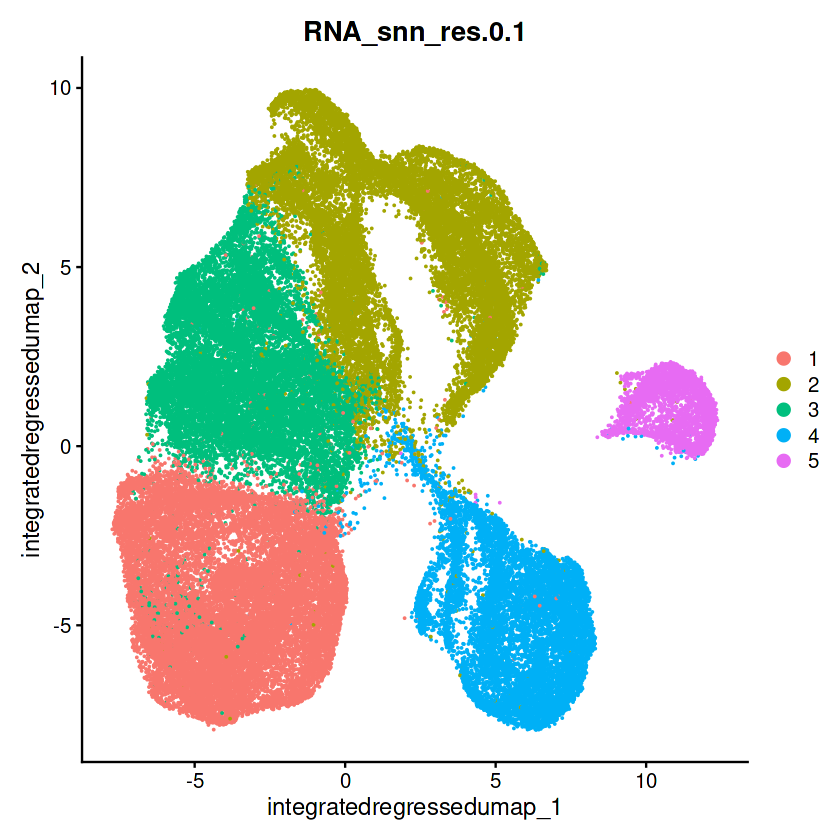

In [36]:
DimPlot(neu_data,group.by = "RNA_snn_res.0.1",reduction = "integrated_regressed_umap")

In [35]:
Reductions(neu_data)

[1] "noregress_pca"               "pca"                        
[3] "unintegrated_noregress_umap" "unintegrated_regressed_umap"
[5] "integrated.jointpca"         "integrated_regressed_umap"

In [37]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3726030,199,5507427,294.2,5507427,294.2
Vcells,978317451,7464,2786739734,21261.2,2902773329,22146.5


In [4]:
# 读取mouseTFs.tsv文件
mouseTFs <- read.table("../mouseTFs.tsv", header = FALSE, stringsAsFactors = FALSE,fill = TRUE)

In [5]:
head(mouseTFs)

,V1,V2
,<chr>,<chr>
1,ENSMUSG00000000078,Klf6
2,ENSMUSG00000000085,Scmh1
3,ENSMUSG00000000093,Tbx2
4,ENSMUSG00000000094,Tbx4
5,ENSMUSG00000000103,Zfy2
6,ENSMUSG00000000134,Tfe3


In [6]:
library(scCustomize)

scCustomize v2.1.2
If you find the scCustomize useful please cite.
See 'samuel-marsh.github.io/scCustomize/articles/FAQ.html' for citation info.



In [7]:
Idents(neu_data)<- "RNA_snn_res.27"

In [8]:
anyNA(mouseTFs$V2)

[1] FALSE

In [12]:
filtered_TFs<- read.csv("./top10_clust27_TF_markers_wilcox.csv")

In [14]:
head(filtered_TFs)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,0,10.074795,0.439,0.001,0,20,Emx1
2,0,9.391512,0.212,0.001,0,242,Irx6
3,0,8.905985,0.692,0.004,0,242,Barhl1
4,0,8.536205,0.507,0.002,0,242,Foxa1
5,0,8.160744,0.459,0.006,0,242,Irx5
6,0,8.135755,0.902,0.014,0,20,Neurod6


In [9]:
tfdotplot<- Clustered_DotPlot(neu_data,unique(mouseTFs$V2),plot_km_elbow = F)

Warning message:
“The following features were omitted as they were not found:
ℹ Hoxd12, Hoxc10, Hoxc5, Foxh1, Hoxa11, Hoxb7, Zufsp, Hoxd11, Hoxa6, Foxe3,
  Prop1, Rhox13, Hoxc12, Hoxd10, , Hoxd3, AC125149.4, AC132444.3, AC168977.2,
  AC125149.5, AC133103.4, AC133103.5, Tgif2lx1, Tgif2lx2, Gm28230, Hoxd4,
  Gm32802, Gm9044, Gm9048, Gm9046, Gm9040, Gm9049, CT573016.1, and AC118475.1”
Warning message:
“You defined `cell_fun` for a heatmap with more than 100 rows or
columns, which might be very slow to draw. Consider to use the
vectorized version `layer_fun`.”


ERROR: Error in hclust(get_dist(submat, distance), method = method): NA/NaN/Inf in foreign function call (arg 10)


In [19]:
   # 如果是ComplexHeatmap对象
   png("tfdotplot_long.png", width = 4000, height = 4000, units = "px")
   tfdotplot
   dev.off()

pdf 
  2

In [11]:
neu_data<- JoinLayers(neu_data)

In [34]:
# 提取neu_data中的表达矩阵
expression_matrix <- GetAssayData(neu_data,layer = "data")

In [36]:

# 获取基因名和细胞名
gene_names <- rownames(expression_matrix)
cell_names <- colnames(expression_matrix)

In [35]:
head(expression_matrix)

  [[ suppressing 34 column names ‘__E11_S1_CTCAACCGTTCTCACC-1’, ‘__E11_S1_GTCCCATGTTACCTGA-1’, ‘__E11_S1_TTCCGTGTCAACGCTA-1’ ... ]]



6 x 67560 sparse Matrix of class "dgCMatrix"
                                                                           
Xkr4    1.8475129 1.2170089 1.755413 0.8683528 1.706276 2.1592269 1.7219204
Gm37180 0.2881829 0.2923574 .        .         .        .         .        
Gm37363 .         0.2923574 .        .         0.297732 0.2989065 0.3026804
Gm37686 .         .         .        .         .        .         .        
Gm1992  .         0.2923574 .        .         .        .         .        
Gm37329 .         .         .        .         .        .         .        
                                                                         
Xkr4    2.3726590 1.8144362 1.9858343 1.986920 2.464082 1.283571 2.093588
Gm37180 .         0.3125984 .         0.314941 .        .        .       
Gm37363 .         .         0.3146013 0.314941 .        .        .       
Gm37686 .         .         .         .        .        .        .       
Gm1992  0.5425772 .         .         .        .     

In [37]:
# 筛选出在mouseTFs$V2中的基因
tf_genes <- intersect(gene_names, mouseTFs$V2)

# 提取这些基因的表达数据
tf_expression_data <- expression_matrix[tf_genes, ]

# 提取RNA_snn_res.27分类信息
cluster_info <- neu_data@meta.data$RNA_snn_res.27
names(cluster_info) <- cell_names  # 确保名称匹配

In [38]:
head(tf_expression_data)

  [[ suppressing 34 column names ‘__E11_S1_CTCAACCGTTCTCACC-1’, ‘__E11_S1_GTCCCATGTTACCTGA-1’, ‘__E11_S1_TTCCGTGTCAACGCTA-1’ ... ]]



6 x 67560 sparse Matrix of class "dgCMatrix"
                                                                            
Sox17  .         .         .         .         .         .         .        
St18   0.2881829 0.2923574 0.5209881 1.7037827 0.5268573 1.1282685 0.3026804
Mybl1  .         0.2923574 .         .         .         .         .        
Tcf24  .         .         .         .         .         .         .        
Prdm14 0.5116269 .         .         .         .         .         .        
Ncoa2  0.9820810 0.5182956 1.2216900 0.8683528 0.5268573 0.7154714 0.7229222
                                                                          
Sox17  .        .         .        .         .         .         .        
St18   1.030008 1.6870783 .        0.5540902 .         2.7670398 1.1775830
Mybl1  .        .         .        .         .         .         0.3180316
Tcf24  .        .         .        .         .         .         0.3180316
Prdm14 .        .         .        .     

In [118]:
# 计算每个聚类的平均表达量
pseudobulk_data <- as.data.frame(tf_expression_data) %>%
  t() %>%
  as.data.frame() %>%
  mutate(Cluster = cluster_info) %>%
  group_by(Cluster) %>%
  summarize(across(everything(), mean))

# 转置数据以便绘制热图
pseudobulk_data <- t(pseudobulk_data)

In [119]:
head(pseudobulk_data)

Cluster,1,2,3,4,5,6,7,8,9,10,⋯,263,264,265,266,267,268,269,270,271,272
Sox17,0.000000000,0.000000000,0.000000000,0.001763299,0.000000000,0.000000000,0.000000000,0.001714109,0.000000000,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
St18,0.503417080,0.311118975,0.301823888,0.096214869,0.516290902,1.287121708,0.350386416,0.909735634,1.163803220,0.021838763,⋯,0.266620179,0.065916432,0.450208233,2.059251027,1.102612029,0.137979036,0.596947276,0.078508563,0.549539425,0.066913114
Mybl1,0.005034306,0.012502775,0.011870816,0.002356562,0.009945992,0.002907431,0.006905104,0.007203884,0.000000000,0.029999261,⋯,0.000000000,0.003097532,0.010092998,0.000000000,0.000000000,0.000000000,0.014768177,0.000000000,0.009633535,0.026909693
Tcf24,0.000000000,0.000000000,0.002247734,0.001241327,0.001863613,0.000000000,0.002740025,0.000000000,0.002894387,0.000000000,⋯,0.003205454,0.010094948,0.000000000,0.010062205,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.010429242
Prdm14,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.002626554,0.000000000,0.002078580,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.010031900


In [120]:
# 将pseudobulk_data转换为数据框
pseudobulk_data <- as.data.frame(pseudobulk_data)
head(pseudobulk_data)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Cluster,1,2,3,4,5,6,7,8,9,10,⋯,263,264,265,266,267,268,269,270,271,272
Sox17,0.000000000,0.000000000,0.000000000,0.001763299,0.000000000,0.000000000,0.000000000,0.001714109,0.000000000,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
St18,0.503417080,0.311118975,0.301823888,0.096214869,0.516290902,1.287121708,0.350386416,0.909735634,1.163803220,0.021838763,⋯,0.266620179,0.065916432,0.450208233,2.059251027,1.102612029,0.137979036,0.596947276,0.078508563,0.549539425,0.066913114
Mybl1,0.005034306,0.012502775,0.011870816,0.002356562,0.009945992,0.002907431,0.006905104,0.007203884,0.000000000,0.029999261,⋯,0.000000000,0.003097532,0.010092998,0.000000000,0.000000000,0.000000000,0.014768177,0.000000000,0.009633535,0.026909693
Tcf24,0.000000000,0.000000000,0.002247734,0.001241327,0.001863613,0.000000000,0.002740025,0.000000000,0.002894387,0.000000000,⋯,0.003205454,0.010094948,0.000000000,0.010062205,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.010429242
Prdm14,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.002626554,0.000000000,0.002078580,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.010031900


In [121]:
# 设置第一行作为列名
colnames(pseudobulk_data) <- as.character(pseudobulk_data[1, ])
head(pseudobulk_data)

,1,2,3,4,5,6,7,8,9,10,⋯,263,264,265,266,267,268,269,270,271,272
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Cluster,1,2,3,4,5,6,7,8,9,10,⋯,263,264,265,266,267,268,269,270,271,272
Sox17,0.000000000,0.000000000,0.000000000,0.001763299,0.000000000,0.000000000,0.000000000,0.001714109,0.000000000,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
St18,0.503417080,0.311118975,0.301823888,0.096214869,0.516290902,1.287121708,0.350386416,0.909735634,1.163803220,0.021838763,⋯,0.266620179,0.065916432,0.450208233,2.059251027,1.102612029,0.137979036,0.596947276,0.078508563,0.549539425,0.066913114
Mybl1,0.005034306,0.012502775,0.011870816,0.002356562,0.009945992,0.002907431,0.006905104,0.007203884,0.000000000,0.029999261,⋯,0.000000000,0.003097532,0.010092998,0.000000000,0.000000000,0.000000000,0.014768177,0.000000000,0.009633535,0.026909693
Tcf24,0.000000000,0.000000000,0.002247734,0.001241327,0.001863613,0.000000000,0.002740025,0.000000000,0.002894387,0.000000000,⋯,0.003205454,0.010094948,0.000000000,0.010062205,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.010429242
Prdm14,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.002626554,0.000000000,0.002078580,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.010031900


In [122]:
pseudobulk_data <- pseudobulk_data[-1, ]  # 删除第一行
head(pseudobulk_data)

,1,2,3,4,5,6,7,8,9,10,⋯,263,264,265,266,267,268,269,270,271,272
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sox17,0.000000000,0.000000000,0.000000000,0.001763299,0.000000000,0.000000000,0.000000000,0.001714109,0.000000000,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
St18,0.503417080,0.311118975,0.301823888,0.096214869,0.516290902,1.287121708,0.350386416,0.909735634,1.163803220,0.021838763,⋯,0.266620179,0.065916432,0.450208233,2.059251027,1.102612029,0.137979036,0.596947276,0.078508563,0.549539425,0.066913114
Mybl1,0.005034306,0.012502775,0.011870816,0.002356562,0.009945992,0.002907431,0.006905104,0.007203884,0.000000000,0.029999261,⋯,0.000000000,0.003097532,0.010092998,0.000000000,0.000000000,0.000000000,0.014768177,0.000000000,0.009633535,0.026909693
Tcf24,0.000000000,0.000000000,0.002247734,0.001241327,0.001863613,0.000000000,0.002740025,0.000000000,0.002894387,0.000000000,⋯,0.003205454,0.010094948,0.000000000,0.010062205,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.010429242
Prdm14,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.002626554,0.000000000,0.002078580,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.010031900
Ncoa2,0.6262073,0.5469368,0.4879178,0.4847118,0.5431644,0.5655041,0.5480126,0.6120417,0.5890315,0.4289658,⋯,0.5133615,0.5803780,0.3844630,0.4348092,0.5274736,0.5571989,0.6005029,0.4615573,0.5806738,0.6148279


In [123]:
head(pseudobulk_data)

,1,2,3,4,5,6,7,8,9,10,⋯,263,264,265,266,267,268,269,270,271,272
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sox17,0.000000000,0.000000000,0.000000000,0.001763299,0.000000000,0.000000000,0.000000000,0.001714109,0.000000000,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
St18,0.503417080,0.311118975,0.301823888,0.096214869,0.516290902,1.287121708,0.350386416,0.909735634,1.163803220,0.021838763,⋯,0.266620179,0.065916432,0.450208233,2.059251027,1.102612029,0.137979036,0.596947276,0.078508563,0.549539425,0.066913114
Mybl1,0.005034306,0.012502775,0.011870816,0.002356562,0.009945992,0.002907431,0.006905104,0.007203884,0.000000000,0.029999261,⋯,0.000000000,0.003097532,0.010092998,0.000000000,0.000000000,0.000000000,0.014768177,0.000000000,0.009633535,0.026909693
Tcf24,0.000000000,0.000000000,0.002247734,0.001241327,0.001863613,0.000000000,0.002740025,0.000000000,0.002894387,0.000000000,⋯,0.003205454,0.010094948,0.000000000,0.010062205,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.010429242
Prdm14,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.002626554,0.000000000,0.002078580,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.010031900
Ncoa2,0.6262073,0.5469368,0.4879178,0.4847118,0.5431644,0.5655041,0.5480126,0.6120417,0.5890315,0.4289658,⋯,0.5133615,0.5803780,0.3844630,0.4348092,0.5274736,0.5571989,0.6005029,0.4615573,0.5806738,0.6148279


In [124]:
rownames(pseudobulk_data)

[1] "Sox17"         "St18"          "Mybl1"         "Tcf24"        
   [5] "Prdm14"        "Ncoa2"         "Msc"           "Terf1"        
   [9] "Tfap2d"        "Tfap2b"        "Zfp451"        "Arid5a"       
  [13] "Npas2"         "Rfx8"          "Pou3f3"        "Stat4"        
  [17] "Stat1"         "Satb2"         "Carf"          "Klf7"         
  [21] "Creb1"         "Ikzf2"         "Zfp142"        "Fev"          
  [25] "Ankzf1"        "Pax3"          "Sp110"         "Sp100"        
  [29] "Gbx2"          "Hes6"          "Twist2"        "Mterf4"       
  [33] "Thap4"         "Tfcp2l1"       "Gli2"          "En1"          
  [37] "Elk4"          "Sox13"         "Gm38394"       "Myog"         
  [41] "Kdm5b"         "Elf3"          "Zfp281"        "Nr5a2"        
  [45] "Lhx9"          "Zbtb41"        "Lhx4"          "Zbtb37"       
  [49] "Prrx1"         "Tbx19"         "Pou2f1"        "Pogk"         
  [53] "Rxrg"          "Lmx1a"         "Pbx1"          "Atf6"         
  [57] "Nr1i3"         "Usf1"          "Nhlh1"         "Zbtb18"       
  [61] "Smyd3"         "Ahctf1"        "Mixl1"         "Hlx"          
  [65] "Esrrg"         "Prox1"         "Batf3"         "Atf3"         
  [69] "Irf6"          "Gata3"         "Kin"           "Ptf1a"        
  [73] "Pax8"          "Bmyc"          "Nacc2"         "Lhx3"         
  [77] "Snapc4"        "Rexo4"         "Rxra"          "Gfi1b"        
  [81] "Barhl1"        "Ttf1"          "Prrx2"         "Prdm12"       
  [85] "Naif1"         "Zbtb34"        "Zbtb43"        "Lmx1b"        
  [89] "Pbx3"          "Phf19"         "Lhx6"          "Zbtb6"        
  [93] "Zbtb26"        "Lhx2"          "Nr5a1"         "Nr6a1"        
  [97] "Zeb2"          "Nr4a2"         "Baz2b"         "Tbr1"         
 [101] "Csrnp3"        "Sp5"           "Dlx1"          "Dlx2"         
 [105] "Sp3"           "Sp9"           "Atf2"          "Evx2"         
 [109] "Nfe2l2"        "Zfp385b"       "Neurod1"       "Zfp804a"      
 [113] "Spi1"          "Nr1h3"         "Zfp408"        "Creb3l1"      
 [117] "Phf21a"        "Alx4"          "Rag1"          "Ehf"          
 [121] "Elf5"          "Pin1rt1"       "Wt1"           "Pax6"         
 [125] "Zfp770"        "Meis2"         "Mga"           "Zscan29"      
 [129] "Kcnip3"        "Zfp661"        "Zc3h8"         "Ebf4"         
 [133] "Cenpb"         "Ovol2"         "Insm1"         "Nkx2-4"       
 [137] "Nkx2-2"        "Pax1"          "Foxa2"         "Gzf1"         
 [141] "Vsx1"          "Scrt2"         "Tcf15"         "Rbck1"        
 [145] "Sox12"         "Foxs1"         "Plagl2"        "E2f1"         
 [149] "Zfp341"        "Phf20"         "Tgif2"         "Mafb"         
 [153] "Zhx3"          "L3mbtl1"       "Mybl2"         "Hnf4a"        
 [157] "Rbpjl"         "Dnttip1"       "Zfp335"        "Zfp334"       
 [161] "Ncoa3"         "Snai1"         "Cebpb"         "Adnp"         
 [165] "Nfatc2"        "Sall4"         "Zfp64"         "Tshz2"        
 [169] "Zfp217"        "Tfap2c"        "Zfp831"        "Gata5"        
 [173] "Tcfl5"         "Bhlhe23"       "Gmeb2"         "Zgpat"        
 [177] "Zbtb46"        "Zfp512b"       "Sox18"         "Myt1"         
 [181] "Foxp3"         "Tfe3"          "Gata1"         "Elk1"         
 [185] "Zfp182"        "Nkrf"          "Zbtb33"        "Elf4"         
 [189] "Zfp280c"       "Zfp449"        "Zic3"          "Sox3"         
 [193] "Zfp275"        "Zfp92"         "Mecp2"         "Nr0b1"        
 [197] "Arx"           "Zfx"           "Ar"            "Foxo4"        
 [201] "Cdx4"          "Tbx22"         "Pou3f4"        "Hdx"          
 [205] "Zfp711"        "Dach2"         "Zmat1"         "Esx1"         
 [209] "Foxr2"         "Klf8"          "Gm15262"       "Hnf4g"        
 [213] "Zfhx4"         "Hey1"          "Zbtb10"        "Zfp704"       
 [217] "E2f5"          "Bhlhe22"       "Mecom"         "Mynn"         
 [221] "Skil"          "Zfp639"        "Sox2"          "Elf2"         
 [225] "Foxo1"         "Soh

In [129]:
# 假设 df 是原始数据框
# 1. 提取行名和列名
row_names <- rownames(pseudobulk_data)  # 获取行名
col_names <- colnames(pseudobulk_data)  # 获取列名

# 2. 将整个数据框转换为数值型
df_numeric <- as.data.frame(lapply(pseudobulk_data, as.numeric))

# 3. 重新设置列名和行名
colnames(df_numeric) <- col_names
rownames(df_numeric) <- row_names

head(df_numeric)

,1,2,3,4,5,6,7,8,9,10,⋯,263,264,265,266,267,268,269,270,271,272
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sox17,0.000000000,0.00000000,0.000000000,0.001763299,0.000000000,0.000000000,0.000000000,0.001714109,0.000000000,0.00000000,⋯,0.000000000,0.000000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.000000000,0.00000000
St18,0.503417080,0.31111898,0.301823888,0.096214869,0.516290902,1.287121708,0.350386416,0.909735634,1.163803220,0.02183876,⋯,0.266620179,0.065916432,0.4502082,2.0592510,1.1026120,0.1379790,0.59694728,0.07850856,0.549539425,0.06691311
Mybl1,0.005034306,0.01250278,0.011870816,0.002356562,0.009945992,0.002907431,0.006905104,0.007203884,0.000000000,0.02999926,⋯,0.000000000,0.003097532,0.0100930,0.0000000,0.0000000,0.0000000,0.01476818,0.00000000,0.009633535,0.02690969
Tcf24,0.000000000,0.00000000,0.002247734,0.001241327,0.001863613,0.000000000,0.002740025,0.000000000,0.002894387,0.00000000,⋯,0.003205454,0.010094948,0.0000000,0.0100622,0.0000000,0.0000000,0.00000000,0.00000000,0.000000000,0.01042924
Prdm14,0.000000000,0.00000000,0.000000000,0.000000000,0.000000000,0.000000000,0.002626554,0.000000000,0.002078580,0.00000000,⋯,0.000000000,0.000000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.000000000,0.01003190
Ncoa2,0.626207300,0.54693680,0.487917800,0.484711800,0.543164400,0.565504100,0.548012600,0.612041700,0.589031500,0.42896580,⋯,0.513361500,0.580378000,0.3844630,0.4348092,0.5274736,0.5571989,0.60050290,0.46155730,0.580673800,0.61482790


In [130]:
# 使用pheatmap可视化并保存为对象
tf_heatmap <- pheatmap(
  df_numeric,
  cluster_rows = TRUE,  # 对行进行聚类
  cluster_cols = TRUE,  # 对列进行聚类
  show_rownames = TRUE,  # 显示行名
  show_colnames = TRUE,  # 显示列名
  main = "Pseudobulk TF Gene Expression Heatmap",  # 图标题
  fontsize = 8,  # 字体大小
  color = colorRampPalette(c("white", "red"))(100),  # 颜色渐变
  silent = TRUE  # 不直接绘制图像
)

In [135]:
# 使用pheatmap可视化并保存为对象
tf_clusterf_heatmap <- pheatmap(
  df_numeric,
  cluster_rows = F,  # 对行进行聚类
  cluster_cols = TRUE,  # 对列进行聚类
  show_rownames = TRUE,  # 显示行名
  show_colnames = TRUE,  # 显示列名
  main = "Pseudobulk TF Gene Expression Heatmap",  # 图标题
  fontsize = 8,  # 字体大小
  color = colorRampPalette(c("white", "red"))(100),  # 颜色渐变
  silent = TRUE  # 不直接绘制图像
)

In [137]:
# 使用pheatmap可视化并保存为对象
tf_cluster_rows_heatmap <- pheatmap(
  df_numeric,
  cluster_rows = T,  # 对行进行聚类
  cluster_cols = F,  # 对列进行聚类
  show_rownames = TRUE,  # 显示行名
  show_colnames = TRUE,  # 显示列名
  main = "Pseudobulk TF Gene Expression Heatmap",  # 图标题
  fontsize = 8,  # 字体大小
  color = colorRampPalette(c("white", "red"))(100),  # 颜色渐变
  silent = TRUE  # 不直接绘制图像
)

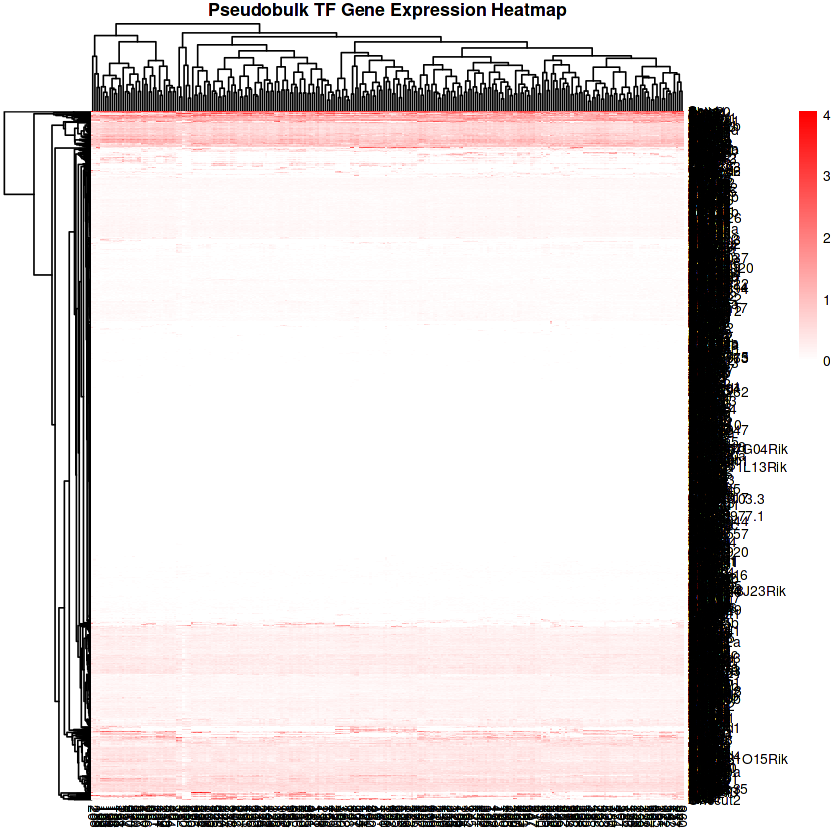

In [132]:
tf_heatmap

In [134]:
# 保存热图
ggsave("tf_heatmap.svg", plot = tf_heatmap, width = 40, height = 140, dpi = 300,limitsize = F)

In [136]:
# 保存热图
ggsave("tf_clusterf_heatmap.svg", plot = tf_clusterf_heatmap, width = 40, height = 140, dpi = 300,limitsize = F)

In [138]:

# 保存热图
ggsave("tf_cluster_rows_heatmap.svg", plot = tf_cluster_rows_heatmap, width = 40, height = 140, dpi = 300,limitsize = F)

In [139]:
saveRDS(expression_matrix,"./neu_exp_matrix.rds")

In [140]:
saveRDS(pseudobulk_data,"./neu_pseudobulk_data.rds")

In [1]:
pseudobulk_data<-readRDS("./neu_pseudobulk_data.rds")

In [2]:
# install.packages("cluster")

Installing package into ‘/home/mint/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)



In [2]:
library(cluster)

In [21]:
agn <- agnes(pseudobulk_data, metric = "euclidean", method = "average")

Warning message in plot.window(xlim, ylim, log = log, ...):
“"hang" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"hang" is not a graphical parameter”
Warning message in axis(1, at = at.vals, labels = lab.vals, ...):
“"hang" is not a graphical parameter”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“"hang" is not a graphical parameter”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“"hang" is not a graphical parameter”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“"hang" is not a graphical parameter”


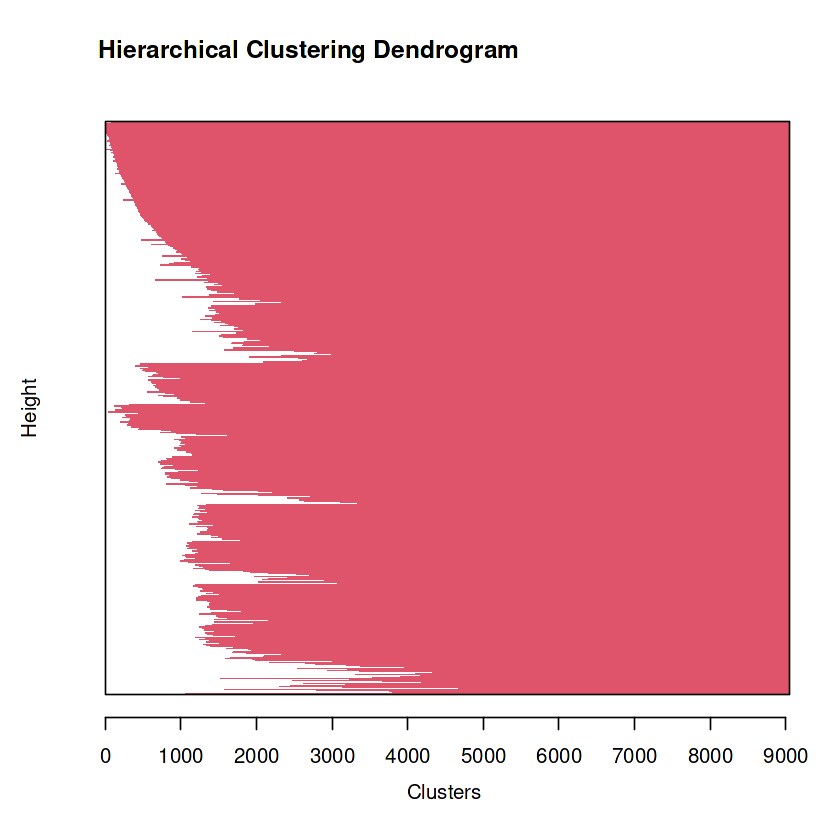

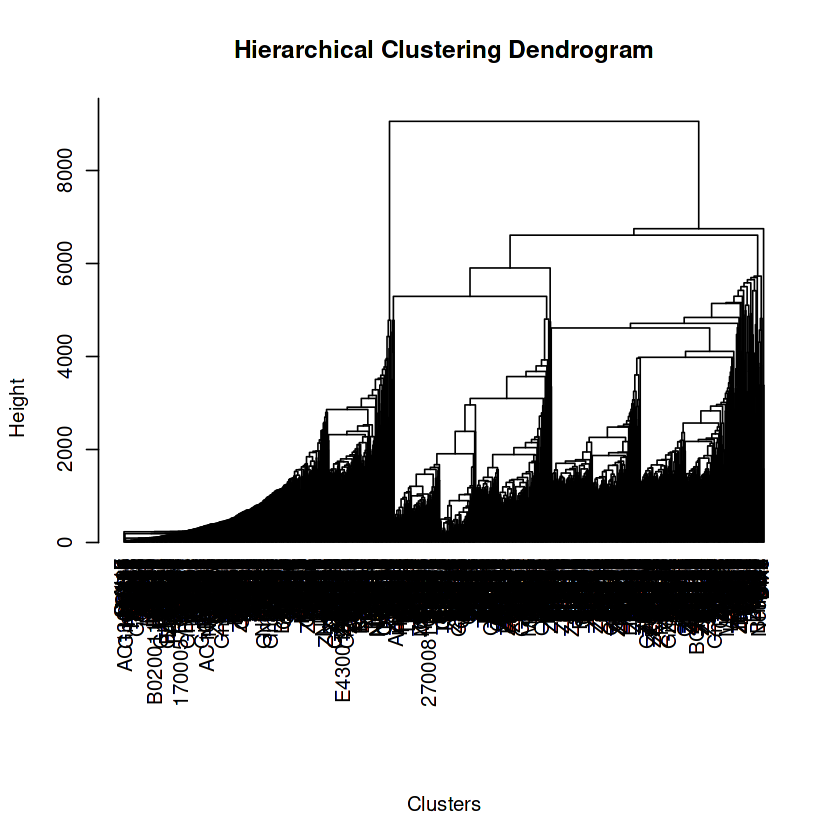

In [22]:
plot(agn, main = "Hierarchical Clustering Dendrogram", xlab = "Clusters", ylab = "Height", sub = "", hang = -1)

In [6]:
head(pseudobulk_data)

,1,2,3,4,5,6,7,8,9,10,⋯,263,264,265,266,267,268,269,270,271,272
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sox17,0.000000000,0.000000000,0.000000000,0.001763299,0.000000000,0.000000000,0.000000000,0.001714109,0.000000000,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
St18,0.503417080,0.311118975,0.301823888,0.096214869,0.516290902,1.287121708,0.350386416,0.909735634,1.163803220,0.021838763,⋯,0.266620179,0.065916432,0.450208233,2.059251027,1.102612029,0.137979036,0.596947276,0.078508563,0.549539425,0.066913114
Mybl1,0.005034306,0.012502775,0.011870816,0.002356562,0.009945992,0.002907431,0.006905104,0.007203884,0.000000000,0.029999261,⋯,0.000000000,0.003097532,0.010092998,0.000000000,0.000000000,0.000000000,0.014768177,0.000000000,0.009633535,0.026909693
Tcf24,0.000000000,0.000000000,0.002247734,0.001241327,0.001863613,0.000000000,0.002740025,0.000000000,0.002894387,0.000000000,⋯,0.003205454,0.010094948,0.000000000,0.010062205,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.010429242
Prdm14,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.002626554,0.000000000,0.002078580,0.000000000,⋯,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.010031900
Ncoa2,0.6262073,0.5469368,0.4879178,0.4847118,0.5431644,0.5655041,0.5480126,0.6120417,0.5890315,0.4289658,⋯,0.5133615,0.5803780,0.3844630,0.4348092,0.5274736,0.5571989,0.6005029,0.4615573,0.5806738,0.6148279


In [5]:
# 转置数据
pseudobulk_data_t <- t(pseudobulk_data)

In [6]:
head(pseudobulk_data_t)

,Sox17,St18,Mybl1,Tcf24,Prdm14,Ncoa2,Msc,Terf1,Tfap2d,Tfap2b,⋯,Isx,Foxi1,Zfy2,Zfp648,Noto,Zfp42,Hoxc8,Hoxc6,Rhox10,Hoxb5
1,0.000000000,0.503417080,0.005034306,0.000000000,0.000000000,0.6262073,0.0000000000,0.1670953,0.0000000000,0.002307242,⋯,0.000000000,0,0.000000000,0,0.000000000,0,0,0,0,0
2,0.000000000,0.311118975,0.012502775,0.000000000,0.000000000,0.5469368,0.0000000000,0.1647628,0.0000000000,0.000000000,⋯,0.000000000,0,0.000000000,0,0.000000000,0,0,0,0,0
3,0.000000000,0.301823888,0.011870816,0.002247734,0.000000000,0.4879178,0.0082220249,0.1364812,0.0000000000,0.000000000,⋯,0.000000000,0,0.000000000,0,0.000000000,0,0,0,0,0
4,0.001763299,0.096214869,0.002356562,0.001241327,0.000000000,0.4847118,0.0051696625,0.1703827,0.0000000000,0.000000000,⋯,0.000000000,0,0.000000000,0,0.000000000,0,0,0,0,0
5,0.000000000,0.516290902,0.009945992,0.001863613,0.000000000,0.5431644,0.0000000000,0.2435105,0.0000000000,0.000000000,⋯,0.000000000,0,0.000000000,0,0.000000000,0,0,0,0,0
6,0.000000000,1.287121708,0.002907431,0.000000000,0.000000000,0.5655041,0.0000000000,0.1521819,0.0020735432,0.000000000,⋯,0.000000000,0,0.000000000,0,0.000000000,0,0,0,0,0


In [7]:
pseudobulk_data_t <- as.data.frame(pseudobulk_data_t)
head(pseudobulk_data_t)

,Sox17,St18,Mybl1,Tcf24,Prdm14,Ncoa2,Msc,Terf1,Tfap2d,Tfap2b,⋯,Isx,Foxi1,Zfy2,Zfp648,Noto,Zfp42,Hoxc8,Hoxc6,Rhox10,Hoxb5
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,0.000000000,0.503417080,0.005034306,0.000000000,0.000000000,0.6262073,0.0000000000,0.1670953,0.0000000000,0.002307242,⋯,0.000000000,0,0.000000000,0,0.000000000,0,0,0,0,0
2,0.000000000,0.311118975,0.012502775,0.000000000,0.000000000,0.5469368,0.0000000000,0.1647628,0.0000000000,0.000000000,⋯,0.000000000,0,0.000000000,0,0.000000000,0,0,0,0,0
3,0.000000000,0.301823888,0.011870816,0.002247734,0.000000000,0.4879178,0.0082220249,0.1364812,0.0000000000,0.000000000,⋯,0.000000000,0,0.000000000,0,0.000000000,0,0,0,0,0
4,0.001763299,0.096214869,0.002356562,0.001241327,0.000000000,0.4847118,0.0051696625,0.1703827,0.0000000000,0.000000000,⋯,0.000000000,0,0.000000000,0,0.000000000,0,0,0,0,0
5,0.000000000,0.516290902,0.009945992,0.001863613,0.000000000,0.5431644,0.0000000000,0.2435105,0.0000000000,0.000000000,⋯,0.000000000,0,0.000000000,0,0.000000000,0,0,0,0,0
6,0.000000000,1.287121708,0.002907431,0.000000000,0.000000000,0.5655041,0.0000000000,0.1521819,0.0020735432,0.000000000,⋯,0.000000000,0,0.000000000,0,0.000000000,0,0,0,0,0


In [8]:
pseudobulk_data_t[] <- lapply(pseudobulk_data_t, as.numeric)  # 确保所有列都是数值型
head(pseudobulk_data_t)

,Sox17,St18,Mybl1,Tcf24,Prdm14,Ncoa2,Msc,Terf1,Tfap2d,Tfap2b,⋯,Isx,Foxi1,Zfy2,Zfp648,Noto,Zfp42,Hoxc8,Hoxc6,Rhox10,Hoxb5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.000000000,0.50341708,0.005034306,0.000000000,0,0.6262073,0.000000000,0.1670953,0.000000000,0.002307242,⋯,0,0,0,0,0,0,0,0,0,0
2,0.000000000,0.31111898,0.012502775,0.000000000,0,0.5469368,0.000000000,0.1647628,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
3,0.000000000,0.30182389,0.011870816,0.002247734,0,0.4879178,0.008222025,0.1364812,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
4,0.001763299,0.09621487,0.002356562,0.001241327,0,0.4847118,0.005169662,0.1703827,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
5,0.000000000,0.51629090,0.009945992,0.001863613,0,0.5431644,0.000000000,0.2435105,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
6,0.000000000,1.28712171,0.002907431,0.000000000,0,0.5655041,0.000000000,0.1521819,0.002073543,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0


In [9]:
agn_clusters <- agnes(pseudobulk_data_t, metric = "euclidean", method = "average")

In [16]:
names(agn_clusters)

[1] "order"     "height"    "ac"        "merge"     "diss"      "call"     
[7] "method"    "order.lab" "data"

In [16]:
# 保存聚类树状图为PDF文件
pdf("agn_clusters_dendrogram.pdf", width = 48, height = 6)  # 设置文件名和图形尺寸
plot(agn_clusters, 
     main = "Hierarchical Clustering Dendrogram", 
     xlab = "Clusters", 
     ylab = "Height", 
     sub = "", 
     hang = -1)  # 绘制聚类树状图
dev.off()  # 关闭图形设备

Warning message in plot.window(xlim, ylim, log = log, ...):
“"hang" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"hang" is not a graphical parameter”
Warning message in axis(1, at = at.vals, labels = lab.vals, ...):
“"hang" is not a graphical parameter”


pdf 
  2

In [18]:
# 读取注释列表，跳过前两行，第三行作为列名
anno_table <- read.csv("/mnt/data/projects/cellxgene_VIP/neu_annotation-cell-labels-3SAOHPOQ.csv", 
                        skip = 2,  # 跳过前两行
                        header = TRUE)  # 第三行作为列名
head(anno_table)  # 查看数据框的前几行

,cell,H1_celltype_ver1,H2_GABA_GLU_celltype_ver1,H2_NT_celltype_ver1,H2_NP_celltype_ver1,H2_NP_celltype_ver1_renamed,H2_NP_celltype_ver1_merged,H2_TF_ver1,res27
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,__E11_S1_CTCAACCGTTCTCACC-1,GLU,GLU,272,272-unknow,unknow,unknow,272-Tbr1-Pax6,272
2,__E11_S1_GTCCCATGTTACCTGA-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3
3,__E11_S1_TTCCGTGTCAACGCTA-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3
4,__E11_S1_GCGTTTCAGAATTGCA-1,GABA,GABA,221,221-unknow,unknow,unknow,221-Foxg1-Satb2,221
5,__E11_S1_GAAGCGACATTGGATC-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3
6,__E11_S1_CCGTGAGTCTGTCTCG-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3


In [19]:
# 提取res27和H2_TF_ver1列
res27 <- anno_table$res27
H2_TF_ver1 <- anno_table$H2_TF_ver1

# 创建一个数据框来建立对应关系
correspondence <- data.frame(res27 = res27, H2_TF_ver1 = H2_TF_ver1)

# 查看对应关系
head(correspondence)

,res27,H2_TF_ver1
,<int>,<chr>
1,272,272-Tbr1-Pax6
2,3,3-Myc-Tcf7I2
3,3,3-Myc-Tcf7I2
4,221,221-Foxg1-Satb2
5,3,3-Myc-Tcf7I2
6,3,3-Myc-Tcf7I2


In [20]:
correspondence<- unique(correspondence)
head(correspondence)

,res27,H2_TF_ver1
,<int>,<chr>
1,272,272-Tbr1-Pax6
2,3,3-Myc-Tcf7I2
4,221,221-Foxg1-Satb2
7,192,192-Onecut3-Sim2
8,12,12-Otp-Sim1
9,52,52-Tbx19-Sox6


In [21]:
# 假设pseudobulk_data_t是一个数据框，行名需要替换
# 示例数据框
# pseudobulk_data_t <- data.frame(matrix(rnorm(100), nrow = 10))
# rownames(pseudobulk_data_t) <- paste("old_name", 1:10, sep = "_")

# 查看原始行名
print("原始行名:")
print(rownames(pseudobulk_data_t))

# 使用correspondence中的信息替换行名
# 创建一个查找向量
lookup_vector <- correspondence$res27
replacement_vector <- correspondence$H2_TF_ver1

# 替换行名
new_rownames <- rownames(pseudobulk_data_t)

# 查找并替换
for (i in seq_along(lookup_vector)) {
  new_rownames[new_rownames == lookup_vector[i]] <- replacement_vector[i]
}

# 更新pseudobulk_data_t的行名
rownames(pseudobulk_data_t) <- new_rownames

# 查看替换后的行名
print("替换后的行名:")
print(rownames(pseudobulk_data_t))

[1] "原始行名:"
  [1] "1"   "2"   "3"   "4"   "5"   "6"   "7"   "8"   "9"   "10"  "11"  "12" 
 [13] "13"  "14"  "15"  "16"  "17"  "18"  "19"  "20"  "21"  "22"  "23"  "24" 
 [25] "25"  "26"  "27"  "28"  "29"  "30"  "31"  "32"  "33"  "34"  "35"  "36" 
 [37] "37"  "38"  "39"  "40"  "41"  "42"  "43"  "44"  "45"  "46"  "47"  "48" 
 [49] "49"  "50"  "51"  "52"  "53"  "54"  "55"  "56"  "57"  "58"  "59"  "60" 
 [61] "61"  "62"  "63"  "64"  "65"  "66"  "67"  "68"  "69"  "70"  "71"  "72" 
 [73] "73"  "74"  "75"  "76"  "77"  "78"  "79"  "80"  "81"  "82"  "83"  "84" 
 [85] "85"  "86"  "87"  "88"  "89"  "90"  "91"  "92"  "93"  "94"  "95"  "96" 
 [97] "97"  "98"  "99"  "100" "101" "102" "103" "104" "105" "106" "107" "108"
[109] "109" "110" "111" "112" "113" "114" "115" "116" "117" "118" "119" "120"
[121] "121" "122" "123" "124" "125" "126" "127" "128" "129" "130" "131" "132"
[133] "133" "134" "135" "136" "137" "138" "139" "140" "141" "142" "143" "144"
[145] "145" "146" "147" "148" "149" "150" "151" "152

In [17]:
agn_anno_clusters <- agnes(pseudobulk_data_t, metric = "euclidean", method = "average")

In [18]:
# 保存聚类树状图为PDF文件
pdf("agn_anno_clusters_dendrogram.pdf", width = 148, height = 6)  # 设置文件名和图形尺寸
plot(agn_anno_clusters, 
     main = "Hierarchical Clustering Dendrogram", 
     xlab = "Clusters", 
     ylab = "Height", 
     sub = "", 
     hang = -1)  # 绘制聚类树状图
dev.off()  # 关闭图形设备

Warning message in plot.window(xlim, ylim, log = log, ...):
“"hang" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"hang" is not a graphical parameter”
Warning message in axis(1, at = at.vals, labels = lab.vals, ...):
“"hang" is not a graphical parameter”


pdf 
  2

In [54]:
# 创建新的列，将三列组合成一个新的值
anno_table$combined_column <- paste(anno_table$H2_GABA_GLU_celltype_ver1, 
    anno_table$H2_NT_celltype_ver1,
    anno_table$H2_NP_celltype_ver1,
    anno_table$H2_TF_ver1,
    sep = "-"
)

# 查看更新后的数据框
head(anno_table)


,cell,H1_celltype_ver1,H2_GABA_GLU_celltype_ver1,H2_NT_celltype_ver1,H2_NP_celltype_ver1,H2_NP_celltype_ver1_renamed,H2_NP_celltype_ver1_merged,H2_TF_ver1,res27,combined_column
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,__E11_S1_CTCAACCGTTCTCACC-1,GLU,GLU,272,272-unknow,unknow,unknow,272-Tbr1-Pax6,272,GLU-272-272-unknow-272-Tbr1-Pax6
2,__E11_S1_GTCCCATGTTACCTGA-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3,GLU-3-3-Pomc-3-Myc-Tcf7I2
3,__E11_S1_TTCCGTGTCAACGCTA-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3,GLU-3-3-Pomc-3-Myc-Tcf7I2
4,__E11_S1_GCGTTTCAGAATTGCA-1,GABA,GABA,221,221-unknow,unknow,unknow,221-Foxg1-Satb2,221,GABA-221-221-unknow-221-Foxg1-Satb2
5,__E11_S1_GAAGCGACATTGGATC-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3,GLU-3-3-Pomc-3-Myc-Tcf7I2
6,__E11_S1_CCGTGAGTCTGTCTCG-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3,GLU-3-3-Pomc-3-Myc-Tcf7I2


In [25]:
anno_table$new_column <- NULL

In [55]:
# 去除combined_column中的"unknow-"文本
anno_table$combined_column <- gsub("unknow-", "", anno_table$combined_column)

# 查看更新后的数据框
head(anno_table)

,cell,H1_celltype_ver1,H2_GABA_GLU_celltype_ver1,H2_NT_celltype_ver1,H2_NP_celltype_ver1,H2_NP_celltype_ver1_renamed,H2_NP_celltype_ver1_merged,H2_TF_ver1,res27,combined_column
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,__E11_S1_CTCAACCGTTCTCACC-1,GLU,GLU,272,272-unknow,unknow,unknow,272-Tbr1-Pax6,272,GLU-272-272-272-Tbr1-Pax6
2,__E11_S1_GTCCCATGTTACCTGA-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3,GLU-3-3-Pomc-3-Myc-Tcf7I2
3,__E11_S1_TTCCGTGTCAACGCTA-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3,GLU-3-3-Pomc-3-Myc-Tcf7I2
4,__E11_S1_GCGTTTCAGAATTGCA-1,GABA,GABA,221,221-unknow,unknow,unknow,221-Foxg1-Satb2,221,GABA-221-221-221-Foxg1-Satb2
5,__E11_S1_GAAGCGACATTGGATC-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3,GLU-3-3-Pomc-3-Myc-Tcf7I2
6,__E11_S1_CCGTGAGTCTGTCTCG-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3,GLU-3-3-Pomc-3-Myc-Tcf7I2


In [27]:
# 只去除第一个匹配的"-d", "-dd" 或 "-ddd" 这种格式的文本
anno_table$combined_column <- sub("-\\d\\d?\\d?", "", anno_table$combined_column)

# 查看更新后的数据框
head(anno_table)


,cell,H1_celltype_ver1,H2_GABA_GLU_celltype_ver1,H2_NT_celltype_ver1,H2_NP_celltype_ver1,H2_NP_celltype_ver1_renamed,H2_NP_celltype_ver1_merged,H2_TF_ver1,res27,combined_column
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
1,__E11_S1_CTCAACCGTTCTCACC-1,GLU,GLU,272,272-unknow,unknow,unknow,272-Tbr1-Pax6,272,GLU-272-Tbr1-Pax6
2,__E11_S1_GTCCCATGTTACCTGA-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3,GLU-Pomc-3-Myc-Tcf7I2
3,__E11_S1_TTCCGTGTCAACGCTA-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3,GLU-Pomc-3-Myc-Tcf7I2
4,__E11_S1_GCGTTTCAGAATTGCA-1,GABA,GABA,221,221-unknow,unknow,unknow,221-Foxg1-Satb2,221,GABA-221-Foxg1-Satb2
5,__E11_S1_GAAGCGACATTGGATC-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3,GLU-Pomc-3-Myc-Tcf7I2
6,__E11_S1_CCGTGAGTCTGTCTCG-1,GLU,GLU,3,3-Pomc,3-Pomc,3-Pomc,3-Myc-Tcf7I2,3,GLU-Pomc-3-Myc-Tcf7I2


In [56]:
# 提取res27和H2_TF_ver1列
res27 <- anno_table$res27
combined <- anno_table$combined_column

# 创建一个数据框来建立对应关系
correspondence <- data.frame(res27 = res27, combined = combined)

# 查看对应关系
head(correspondence)

,res27,combined
,<int>,<chr>
1,272,GLU-272-272-272-Tbr1-Pax6
2,3,GLU-3-3-Pomc-3-Myc-Tcf7I2
3,3,GLU-3-3-Pomc-3-Myc-Tcf7I2
4,221,GABA-221-221-221-Foxg1-Satb2
5,3,GLU-3-3-Pomc-3-Myc-Tcf7I2
6,3,GLU-3-3-Pomc-3-Myc-Tcf7I2


In [57]:
anno_table<-unique(correspondence)

In [30]:
pseudobulk_data_t

,Sox17,St18,Mybl1,Tcf24,Prdm14,Ncoa2,Msc,Terf1,Tfap2d,Tfap2b,⋯,Isx,Foxi1,Zfy2,Zfp648,Noto,Zfp42,Hoxc8,Hoxc6,Rhox10,Hoxb5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1-Sox14,0.000000000,0.50341708,0.005034306,0.000000000,0.000000000,0.6262073,0.000000000,0.1670953,0.0000000000,0.002307242,⋯,0,0,0,0,0.000000000,0,0,0,0,0
2-Isl1-Sox6,0.000000000,0.31111898,0.012502775,0.000000000,0.000000000,0.5469368,0.000000000,0.1647628,0.0000000000,0.000000000,⋯,0,0,0,0,0.000000000,0,0,0,0,0
3-Myc-Tcf7I2,0.000000000,0.30182389,0.011870816,0.002247734,0.000000000,0.4879178,0.008222025,0.1364812,0.0000000000,0.000000000,⋯,0,0,0,0,0.000000000,0,0,0,0,0
4-Nkx2.1-Nr2f2,0.001763299,0.09621487,0.002356562,0.001241327,0.000000000,0.4847118,0.005169662,0.1703827,0.0000000000,0.000000000,⋯,0,0,0,0,0.000000000,0,0,0,0,0
5-Sox14-Nkx2.2,0.000000000,0.51629090,0.009945992,0.001863613,0.000000000,0.5431644,0.000000000,0.2435105,0.0000000000,0.000000000,⋯,0,0,0,0,0.000000000,0,0,0,0,0
6-Lhx6-Nfix,0.000000000,1.28712171,0.002907431,0.000000000,0.000000000,0.5655041,0.000000000,0.1521819,0.0020735432,0.000000000,⋯,0,0,0,0,0.000000000,0,0,0,0,0
7-Hmx2-Rorb,0.000000000,0.35038642,0.006905104,0.002740025,0.002626554,0.5480126,0.000000000,0.1476335,0.0000000000,0.000000000,⋯,0,0,0,0,0.000000000,0,0,0,0,0
8-Tbx19-Gsx1,0.001714109,0.90973563,0.007203884,0.000000000,0.000000000,0.6120417,0.000000000,0.2168507,0.0000000000,0.000000000,⋯,0,0,0,0,0.000000000,0,0,0,0,0
9-Plagl1-Etv1,0.000000000,1.16380322,0.000000000,0.002894387,0.002078580,0.5890315,0.000000000,0.1757220,0.0000000000,0.000000000,⋯,0,0,0,0,0.000000000,0,0,0,0,0


In [31]:
pseudobulk_data<-readRDS("./neu_pseudobulk_data.rds")
# 转置数据
pseudobulk_data_t <- t(pseudobulk_data)
pseudobulk_data_t <- as.data.frame(pseudobulk_data_t)
pseudobulk_data_t[] <- lapply(pseudobulk_data_t, as.numeric)  # 确保所有列都是数值型
head(pseudobulk_data_t)

,Sox17,St18,Mybl1,Tcf24,Prdm14,Ncoa2,Msc,Terf1,Tfap2d,Tfap2b,⋯,Isx,Foxi1,Zfy2,Zfp648,Noto,Zfp42,Hoxc8,Hoxc6,Rhox10,Hoxb5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.000000000,0.50341708,0.005034306,0.000000000,0,0.6262073,0.000000000,0.1670953,0.000000000,0.002307242,⋯,0,0,0,0,0,0,0,0,0,0
2,0.000000000,0.31111898,0.012502775,0.000000000,0,0.5469368,0.000000000,0.1647628,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
3,0.000000000,0.30182389,0.011870816,0.002247734,0,0.4879178,0.008222025,0.1364812,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
4,0.001763299,0.09621487,0.002356562,0.001241327,0,0.4847118,0.005169662,0.1703827,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
5,0.000000000,0.51629090,0.009945992,0.001863613,0,0.5431644,0.000000000,0.2435105,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
6,0.000000000,1.28712171,0.002907431,0.000000000,0,0.5655041,0.000000000,0.1521819,0.002073543,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0


In [58]:
# 假设pseudobulk_data_t是一个数据框，行名需要替换
# 查看原始行名
print("原始行名:")
print(rownames(pseudobulk_data_t))

# 检查重复行名
duplicate_rows <- duplicated(rownames(pseudobulk_data_t))
if (any(duplicate_rows)) {
  cat("发现重复的行名:\n")
  print(unique(rownames(pseudobulk_data_t)[duplicate_rows]))
  
  # 处理重复行名，添加后缀
  rownames(pseudobulk_data_t) <- make.unique(rownames(pseudobulk_data_t))
}

# 使用correspondence中的信息替换行名
# 创建一个查找向量
lookup_vector <- correspondence$res27
replacement_vector <- correspondence$combined

# 替换行名
new_rownames <- rownames(pseudobulk_data_t)

# 查找并替换
for (i in seq_along(lookup_vector)) {
  new_rownames[new_rownames == lookup_vector[i]] <- replacement_vector[i]
}

# 更新pseudobulk_data_t的行名
rownames(pseudobulk_data_t) <- new_rownames

# 查看替换后的行名
print("替换后的行名:")
print(rownames(pseudobulk_data_t))

[1] "原始行名:"
  [1] "1-GLU-Sox14"                               
  [2] "2-GABA-Sst-Isl1-Sox6"                      
  [3] "3-GLU-Pomc-Myc-Tcf7I2"                     
  [4] "4-GLU-Cbln1-Nkx2.1-Nr2f2"                  
  [5] "5-GLU-.Cbln1-Sox14-Nkx2.2"                 
  [6] "6-GABA-Lhx6-Nfix"                          
  [7] "7-GABA-Gal-Hmx2-Rorb"                      
  [8] "8-GABA-Tbx19-Gsx1"                         
  [9] "9-GABA-Plagl1-Etv1"                        
 [10] "10-GLU-Cbln1-Ebf1-Zic4"                    
 [11] "11-GABA-Sst-Pou3f1-Isl1"                   
 [12] "12-GLU-Otp-Sim1"                           
 [13] "13-GABA-Sp8-Zeb2"                          
 [14] "14-GABA-Hmx2-Foxg1"                        
 [15] "15-GLU-Cck-Foxb1-Lhx1"                     
 [16] "16-GLU-Emx2-Otx2"                          
 [17] "17-GLU-Hmx2-Lef1"                          
 [18] "18-GABA-Avp-Vgf-Nr1d1-Creb3l1"             
 [19] "19-GLU-Pomc-Prdm12-Sox21"                  
 [20] "20-GLU-Emx1-

In [59]:
head(pseudobulk_data_t)

,Sox17,St18,Mybl1,Tcf24,Prdm14,Ncoa2,Msc,Terf1,Tfap2d,Tfap2b,⋯,Isx,Foxi1,Zfy2,Zfp648,Noto,Zfp42,Hoxc8,Hoxc6,Rhox10,Hoxb5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1-GLU-Sox14,0.000000000,0.50341708,0.005034306,0.000000000,0,0.6262073,0.000000000,0.1670953,0.000000000,0.002307242,⋯,0,0,0,0,0,0,0,0,0,0
2-GABA-Sst-Isl1-Sox6,0.000000000,0.31111898,0.012502775,0.000000000,0,0.5469368,0.000000000,0.1647628,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
3-GLU-Pomc-Myc-Tcf7I2,0.000000000,0.30182389,0.011870816,0.002247734,0,0.4879178,0.008222025,0.1364812,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
4-GLU-Cbln1-Nkx2.1-Nr2f2,0.001763299,0.09621487,0.002356562,0.001241327,0,0.4847118,0.005169662,0.1703827,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
5-GLU-.Cbln1-Sox14-Nkx2.2,0.000000000,0.51629090,0.009945992,0.001863613,0,0.5431644,0.000000000,0.2435105,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
6-GABA-Lhx6-Nfix,0.000000000,1.28712171,0.002907431,0.000000000,0,0.5655041,0.000000000,0.1521819,0.002073543,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0


In [42]:
write.csv(pseudobulk_data_t,"./pseudobulk_data_t.csv")

In [34]:
# # 将行名中的"\d\d?\d?-"挪到行首
# rownames(pseudobulk_data_t) <- sub("^(.*?)(\\d\\d?\\d?-)", "\\2\\1", rownames(pseudobulk_data_t))

# # 查看更新后的行名
# head(pseudobulk_data_t)


,Sox17,St18,Mybl1,Tcf24,Prdm14,Ncoa2,Msc,Terf1,Tfap2d,Tfap2b,⋯,Isx,Foxi1,Zfy2,Zfp648,Noto,Zfp42,Hoxc8,Hoxc6,Rhox10,Hoxb5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1-GLU-Sox14,0.000000000,0.50341708,0.005034306,0.000000000,0,0.6262073,0.000000000,0.1670953,0.000000000,0.002307242,⋯,0,0,0,0,0,0,0,0,0,0
2-GABA-Sst-Isl1-Sox6,0.000000000,0.31111898,0.012502775,0.000000000,0,0.5469368,0.000000000,0.1647628,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
3-GLU-Pomc-Myc-Tcf7I2,0.000000000,0.30182389,0.011870816,0.002247734,0,0.4879178,0.008222025,0.1364812,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
4-GLU-Cbln1-Nkx2.1-Nr2f2,0.001763299,0.09621487,0.002356562,0.001241327,0,0.4847118,0.005169662,0.1703827,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
5-GLU-.Cbln1-Sox14-Nkx2.2,0.000000000,0.51629090,0.009945992,0.001863613,0,0.5431644,0.000000000,0.2435105,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
6-GABA-Lhx6-Nfix,0.000000000,1.28712171,0.002907431,0.000000000,0,0.5655041,0.000000000,0.1521819,0.002073543,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0


In [44]:
agn_combined_anno_clusters <- agnes(pseudobulk_data_t, metric = "euclidean", method = "average")

In [60]:
agn_anno_clusters_ward <- agnes(pseudobulk_data_t, metric = "euclidean", method = "ward")

In [47]:
agn_anno_clusters_complete <- agnes(pseudobulk_data_t, metric = "euclidean", method = "complete")

In [45]:
# 保存聚类树状图为PDF文件
pdf("agn_combined_clusters_dendrogram_avg.pdf", width = 50, height = 10)  # 设置文件名和图形尺寸
plot(agn_combined_anno_clusters, 
     main = "Hierarchical Clustering Dendrogram", 
     xlab = "Clusters", 
     ylab = "Height", 
     sub = "", 
     hang = -1)  # 绘制聚类树状图
dev.off()  # 关闭图形设备

Warning message in plot.window(xlim, ylim, log = log, ...):
“"hang" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"hang" is not a graphical parameter”
Warning message in axis(1, at = at.vals, labels = lab.vals, ...):
“"hang" is not a graphical parameter”


pdf 
  2

In [61]:
# 保存聚类树状图为PDF文件
pdf("agn_anno_clusters_dendrogram_ward.pdf", width = 148, height = 12)  # 设置文件名和图形尺寸
plot(agn_anno_clusters_ward, 
     main = "Hierarchical Clustering Dendrogram", 
     xlab = "Clusters", 
     ylab = "Height", 
     sub = "", 
     hang = -1)  # 绘制聚类树状图
dev.off()  # 关闭图形设备

Warning message in plot.window(xlim, ylim, log = log, ...):
“"hang" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"hang" is not a graphical parameter”
Warning message in axis(1, at = at.vals, labels = lab.vals, ...):
“"hang" is not a graphical parameter”


pdf 
  2

In [48]:
# 保存聚类树状图为PDF文件
pdf("agn_anno_clusters_dendrogram_complete.pdf", width = 148, height = 12)  # 设置文件名和图形尺寸
plot(agn_anno_clusters_complete, 
     main = "Hierarchical Clustering Dendrogram", 
     xlab = "Clusters", 
     ylab = "Height", 
     sub = "", 
     hang = -1)  # 绘制聚类树状图
dev.off()  # 关闭图形设备

Warning message in plot.window(xlim, ylim, log = log, ...):
“"hang" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"hang" is not a graphical parameter”
Warning message in axis(1, at = at.vals, labels = lab.vals, ...):
“"hang" is not a graphical parameter”


pdf 
  2

In [50]:
agn_anno_clusters_single <- agnes(pseudobulk_data_t, metric = "euclidean", method = "single")

In [51]:
# 保存聚类树状图为PDF文件
pdf("agn_anno_clusters_dendrogram_single.pdf", width = 148, height = 12)  # 设置文件名和图形尺寸
plot(agn_anno_clusters_single, 
     main = "Hierarchical Clustering Dendrogram", 
     xlab = "Clusters", 
     ylab = "Height", 
     sub = "", 
     hang = -1)  # 绘制聚类树状图
dev.off()  # 关闭图形设备

Warning message in plot.window(xlim, ylim, log = log, ...):
“"hang" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"hang" is not a graphical parameter”
Warning message in axis(1, at = at.vals, labels = lab.vals, ...):
“"hang" is not a graphical parameter”


pdf 
  2

In [52]:
agn_anno_clusters_gaverage <- agnes(pseudobulk_data_t, metric = "euclidean", method = "gaverage")

In [53]:
# 保存聚类树状图为PDF文件
pdf("agn_anno_clusters_dendrogram_gaverage.pdf", width = 148, height = 12)  # 设置文件名和图形尺寸
plot(agn_anno_clusters_gaverage, 
     main = "Hierarchical Clustering Dendrogram", 
     xlab = "Clusters", 
     ylab = "Height", 
     sub = "", 
     hang = -1)  # 绘制聚类树状图
dev.off()  # 关闭图形设备

Warning message in plot.window(xlim, ylim, log = log, ...):
“"hang" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"hang" is not a graphical parameter”
Warning message in axis(1, at = at.vals, labels = lab.vals, ...):
“"hang" is not a graphical parameter”


pdf 
  2

In [61]:
table(neu_data$Batch)


E11_S1 E11_S2 E13_S1 E14_S1 E14_S2 E15_S1 E15_S2  P0_S1  P0_S2  P7_S1 
  1965   1978   6320  14285  14269   8352   7212   5878   5881   1420 

In [20]:
# 绘制小提琴图并保存为对象
vln_plot <- VlnPlot(neu_data,
                    group.by = "RNA_snn_res.27",
                    features = c("Slc17a6", "Slc32a1"),
                    pt.size = 0,  # 设置点的大小，0表示不显示点
                    ncol = 1)

In [21]:

# 保存为SVG文件
ggsave("violin_plot_markers.svg", 
       plot = vln_plot, 
       width = 80,    # 图片宽度
       height = 12,   # 图片高度
       dpi = 300,limitsize = F)     # 分辨率

In [31]:
vln_list <- VlnPlot(neu_data,
                    features = c("Slc17a6", "Slc32a1"),
                    pt.size = 0,
                    group.by = "orig.ident",
                    ncol = 1,
                    combine = FALSE)  # 确保没有分组

[[1]]

[[2]]


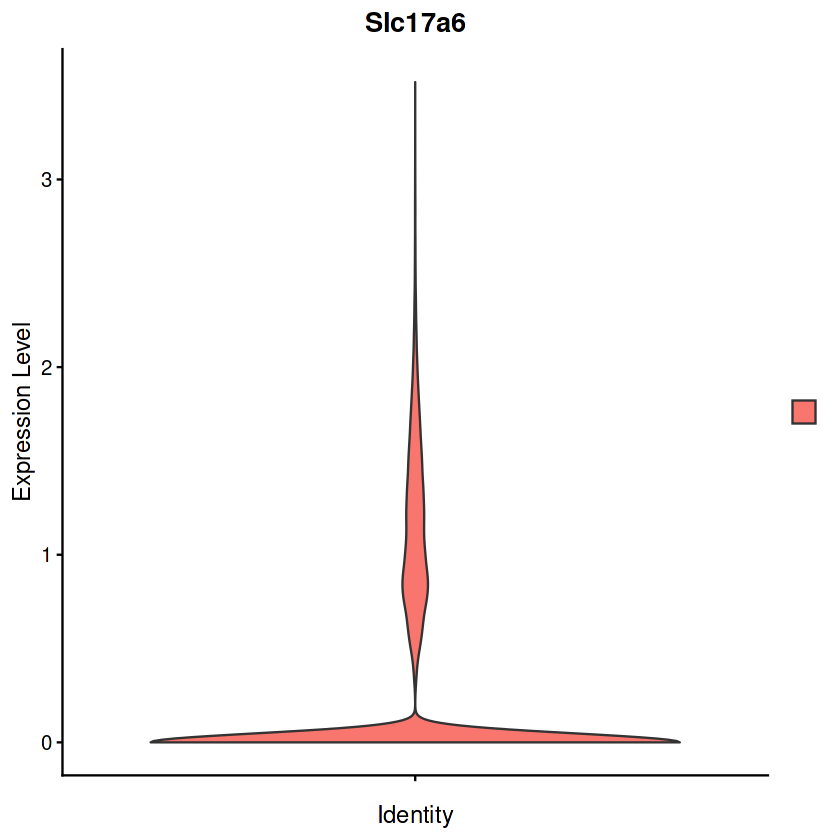

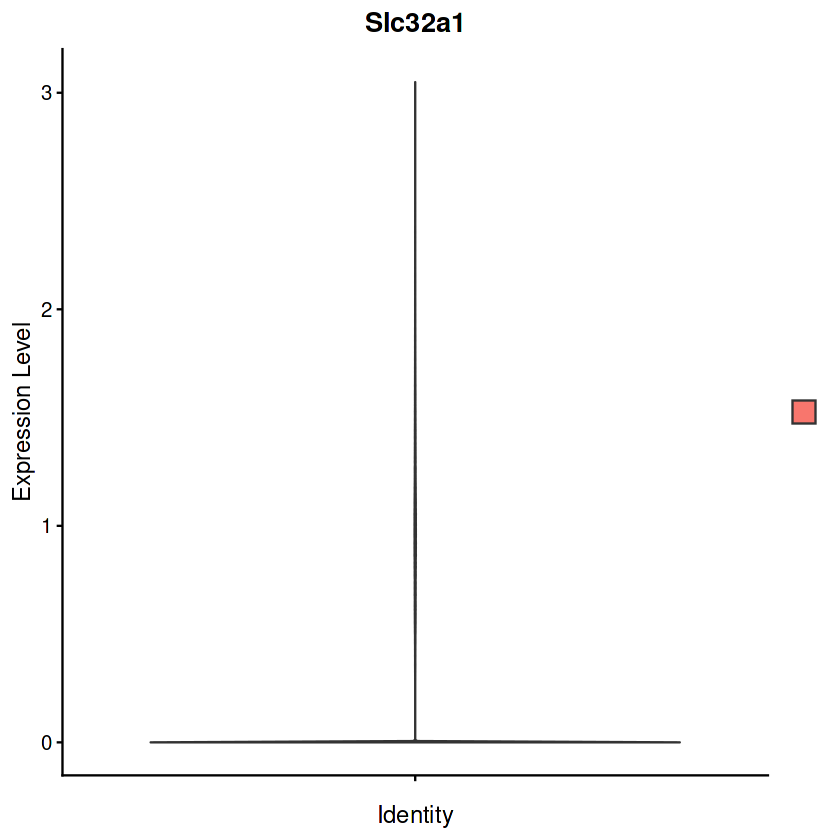

In [32]:
vln_list

In [33]:
Idents(neu_data)<-"RNA_snn_res.27"

In [34]:
clust_53<-subset(neu_data,idents = "53")

[[1]]

[[2]]


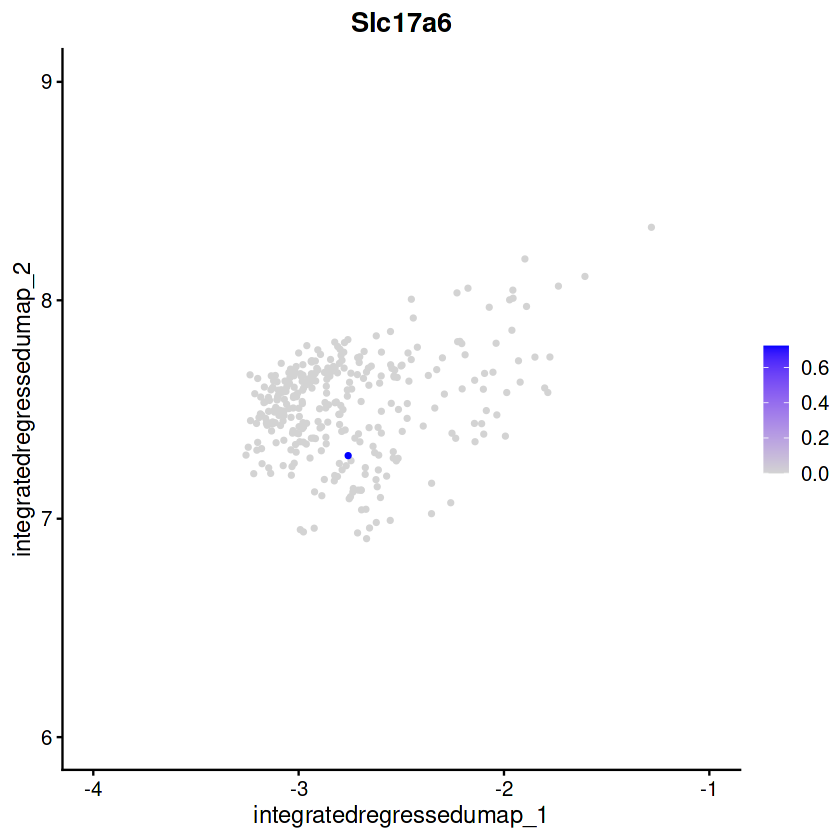

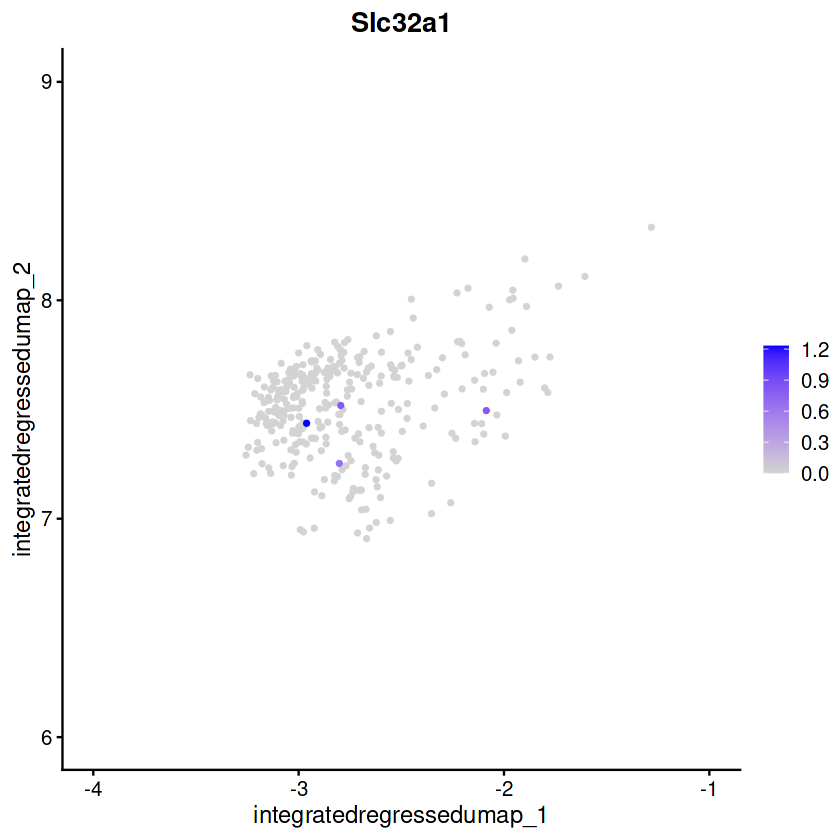

In [56]:
FeaturePlot(clust_53,c("Slc17a6","Slc32a1"),order = T,combine = F,reduction = "integrated_regressed_umap")

In [52]:
clust_139_163_194<-subset(neu_data,idents = c("139","163","194"))

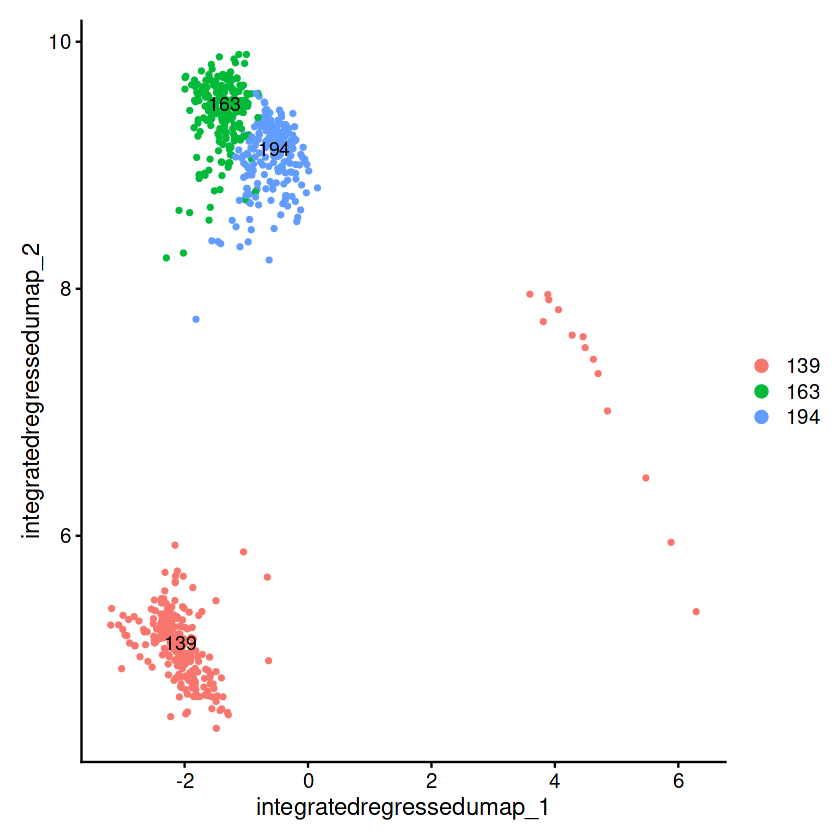

In [57]:
DimPlot(clust_139_163_194,label = T,reduction = "integrated_regressed_umap")

[[1]]

[[2]]


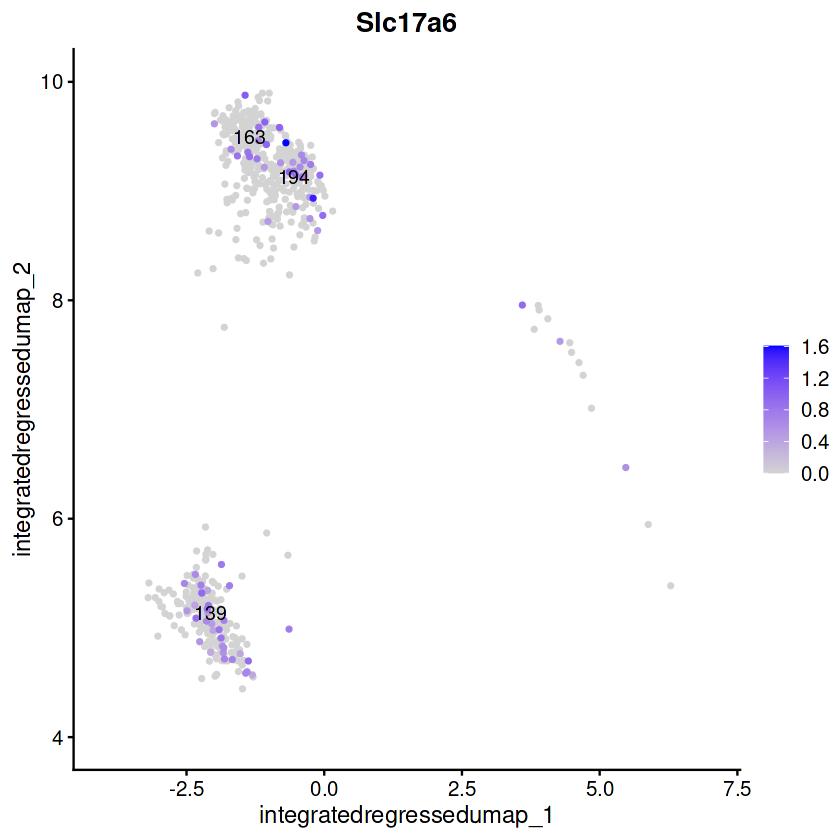

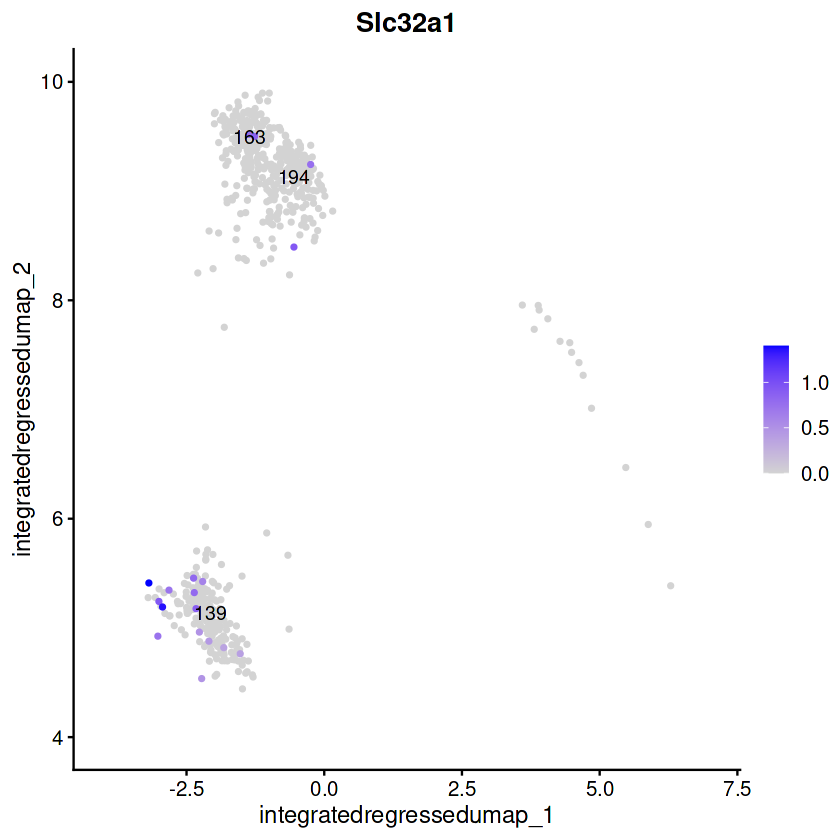

In [58]:
FeaturePlot(clust_139_163_194,c("Slc17a6","Slc32a1"),order = T,combine = F,label = T,reduction = "integrated_regressed_umap")

In [61]:
clust_18<-subset(neu_data,idents = "18")
FeaturePlot(clust_18,c("Gad1","Gad2","Slc6a9"),order = T,combine = F,reduction = "integrated_regressed_umap")

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 't': incorrect number of dimensions


In [62]:
FeaturePlot(clust_18,c("Slc6a9"),order = T,combine = F,reduction = "integrated_regressed_umap")

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 't': incorrect number of dimensions


In [63]:
FeaturePlot(clust_18,c("Hdc"),order = T,combine = F,reduction = "integrated_regressed_umap")

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 't': incorrect number of dimensions


In [67]:
# 绘制小提琴图并保存为对象
gly_hdc_vln_plot <- VlnPlot(neu_data,
                    group.by = "RNA_snn_res.27",
                    features = c("Hdc","Slc6a5","Slc6a9","Gad1","Gad2"),
                    pt.size = 0,  # 设置点的大小，0表示不显示点
                    ncol = 1)

In [68]:
# 保存为SVG文件
ggsave("gly_violin_plot_markers.svg", 
       plot = gly_hdc_vln_plot, 
       width = 80,    # 图片宽度
       height = 32,   # 图片高度
       dpi = 300,limitsize = F)     # 分辨率

In [ ]:
clust_53<-subset(neu_data,idents = "53")
FeaturePlot(clust_53,c("Slc17a6","Slc32a1"),order = T,combine = F)

In [ ]:
clust_53<-subset(neu_data,idents = "53")
FeaturePlot(clust_53,c("Slc17a6","Slc32a1"),order = T,combine = F)

In [ ]:
clust_53<-subset(neu_data,idents = "53")
FeaturePlot(clust_53,c("Slc17a6","Slc32a1"),order = T,combine = F)

In [69]:
# 绘制小提琴图并保存为对象
vglut1_vglut2_vln_plot <- VlnPlot(neu_data,
                    group.by = "RNA_snn_res.27",
                    features = c("Slc17a6","Slc17a7"),
                    pt.size = 0,  # 设置点的大小，0表示不显示点
                    ncol = 1)

In [70]:

# 保存为SVG文件
ggsave("vglut1_vglut2_vln_plot.svg", 
       plot = vglut1_vglut2_vln_plot, 
       width = 80,    # 图片宽度
       height = 12,   # 图片高度
       dpi = 300,limitsize = F)     # 分辨率